# Plot $R^2$ and $\rho$ for Selected Points of a Specific Member-Wise Evaluation

<hr/>

#### Imports

In [1]:
import copy
import os

import math

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from ensemble_uncertainties.automatize import make_folder
from ensemble_uncertainties.utils.ad_assessment import rmses_frac
from ensemble_uncertainties.utils.plotting import plot_confidence, plot_r2

from matplotlib.gridspec import GridSpec

from scipy.stats import spearmanr

from sklearn.metrics import r2_score

#### Constants

In [2]:
N_REPETITIONS = 100
N_SPLITS = 2
DATA_FOLDER = '../../../data/featurized/'
RESULT_FOLDER = '../../../data/results/kfold_ensembles/'
ALLOWED_RANGE_FACTOR = .5

#### Settings

In [3]:
mpl.rcParams['figure.dpi'] = 200

algorithms = ['rf', 'xgb', 'svm_rbf', 'shallow', 'dropout']
algorithm_to_name = {'rf' : 'RF', 'xgb' : 'XGB', 'svm_rbf' : 'SVM', 'shallow' : 'Shallow', 'dropout' : 'Deep'}

descriptors = ['maccs', 'ecfc', 'rdkit', 'cddd']
descriptor_to_name = {'maccs' : 'MACCS', 'ecfc' : 'ECFC', 'rdkit' : 'RDKit', 'cddd' : 'CDDD'}

PLOT_FOLDER = f'./plots/member_wise_examples/'

# Names of the datasets that were already run
dataset_names = [
    'tetrahymena',
    'freesolv',
    'esol',
    'MMP2',
    'IL4',
    'F7',
    'O60674',
    'O14965',
    'P03372',
    'P04150',
    'P06401',
    'P11229',
    'P12931',
    'P16581',
    'P17252',
    'P18089',
    'P19327',
    'P21554',
    'P24530',
    'P25929',
    'P28335',
    'P28482',
    'P35968',
    'P41594',
    'P42345',
    'P47871',
    'P49146',
    'P61169',
    'Q05397',
    'Q16602',
    'P24941',
    'Q92731'
]

#### Functions

In [4]:
def load_results_file(name, algorithm, descriptor, n_repetitions=N_REPETITIONS, n_splits=N_SPLITS):
    """Loads results from disk for a given combination of ML settings."""
    path = f'{RESULT_FOLDER}{name}/{algorithm}/{descriptor}/single_predictions/test.csv'
    results = pd.read_csv(path, sep=';').set_index('id')
    single_tables = list()
    for i in range(n_repetitions):
        partial_results = results[[f'rep{i}_split{j}' for j in range(n_splits)]]
        single_tables.append(partial_results)
    return single_tables


def load_true(name):
    """Loads dependent variables of a given dataset."""
    path = f'{DATA_FOLDER}{name}/{name}_y.csv'
    y = pd.read_csv(path, sep=';').set_index('id')
    return y


def clean_member(member_raw, y):
    """Removes predictions that are outside the allowed y-range"""
    member = copy.deepcopy(member_raw)
    for column in member.columns:
        # To the current column, those indeces
        # that are nan belong to training samples
        train_y = y.loc[member[~member[column].isnull()].index]
        train_y_range = train_y.max() - train_y.min()
        boundary = ALLOWED_RANGE_FACTOR * train_y_range
        allowed_min = (train_y.min() - boundary).values[0]
        allowed_max = (train_y.max() + boundary).values[0]
        exclusion = ((member[column] < allowed_min) | (member[column] > allowed_max))
        member.loc[exclusion] = np.nan
    return member


def clean_from_nan(true, pred, resd, sdev):
    """Returns all 4 lists but without nan entries."""
    altogether = pd.DataFrame(index=true.index)
    altogether['y'] = list(true['y'].values)
    altogether['pred'] = list(pred)
    altogether['resd'] = list(resd.values)
    altogether['sdev'] = list(sdev.values)
    altogether.dropna(subset=['y', 'pred', 'resd', 'sdev'], inplace=True)
    true_clean_df = pd.DataFrame(altogether['y'])
    pred_clean_sr = altogether['pred']
    resd_clean_sr = altogether['resd']
    sdev_clean_sr = altogether['sdev']
    return true_clean_df, pred_clean_sr, resd_clean_sr, sdev_clean_sr


def cumulative_performance(single_tables, y, clean=True):
    """Computes the change in R^2 and uncertainty measure when taking more and more ensemble members into account."""
    members = pd.DataFrame(index=y.index)
    r2_scores = list()
    uqs = list()
    for i, pre_member in enumerate(single_tables):
        # Collect members
        if clean:
            member = clean_member(pre_member, y)
        else:
            member = pre_member
        members = pd.concat([members, member], axis=1)
        # Compute necessary values
        mean = members.mean(axis=1)
        sdev = members.std(axis=1)
        resd = y['y'] - mean
        # Clean in case some values are nan
        y_clean = copy.deepcopy(y)
        if i > 0:
            y_clean, mean, resd, sdev = clean_from_nan(y_clean, mean, resd, sdev)
        mean = mean.dropna()
        y_clean = y_clean.loc[mean.index]
        # Score predictive performance
        r2_scores.append(r2_score(y_clean['y'], mean.values))
        if i > 0:
            # Score uncertainty performance
            uq = spearmanr(resd.abs(), sdev)[0]
            uqs.append(uq)
    r2_scores = np.array(r2_scores)
    uqs = np.array(uqs)
    return r2_scores, uqs


def preds_and_uqs_until_member(single_tables, y, stop_i, clean=True):
    """Computes residuals and UQ values for an ensemble from the first member until a given stop_i (index of the last member)."""
    members = pd.DataFrame(index=y.index)
    if stop_i > len(single_tables):
        print(f'Warning. Ensemble has only {len(single_tables)} members.')
    for i, pre_member in enumerate(single_tables):
        if i == stop_i:
            break
        # Collect members
        if clean:
            member = clean_member(pre_member, y)
        else:
            member = pre_member
        members = pd.concat([members, member], axis=1)   
    # Compute necessary values
    mean = members.mean(axis=1)
    sdev = members.std(axis=1)
    resd = y['y'] - mean
    # Clean in case some values are nan
    y_clean = copy.deepcopy(y)
    if stop_i > 0:
        y_clean, mean, resd, sdev = clean_from_nan(y_clean, mean, resd, sdev)
    mean = mean.dropna()
    mean = pd.DataFrame(mean, columns=['pred'])
    y_clean = y_clean.loc[mean.index]
    if stop_i > 0:
        uqs = sdev
    else:
        uqs = None
    return mean, uqs, y_clean  


def plot_cumulative_scores(values_list, descriptors, ax, y_label, color='k', members_at_points=[], title='', legend=True, text=None, text_loc=None):
    """Plot change over values for several descriptors."""
    ax.grid(zorder=100)
    smallest_y_lim = .0
    for i, (values, descriptor) in enumerate(zip(values_list, descriptors)):
        if y_label == '$R^2$':
            ax.plot([i for i in range(1, len(values)+1)], values, zorder=100+i, label=descriptor_to_name[descriptor], color=color)
            for i, member_point in enumerate(members_at_points):
                ax.scatter([member_point], values[member_point-1], zorder=101+i, color=f'C{i}')
        else:
            ax.plot([i for i in range(2, len(values)+2)], values, zorder=100+i, label=descriptor_to_name[descriptor], color=color)
            for i, member_point in enumerate(members_at_points):
                ax.scatter([member_point], values[member_point-2], zorder=101+i, color=f'C{i}')
        if values.min() < smallest_y_lim:
            smallest_y_lim = values.min()
    ax.set_ylim(smallest_y_lim, 1.)
    ax.set_xlabel('Number of ensemble members')
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    if text and text_loc:
        ax.text(text_loc[0], text_loc[1], text, fontsize=20, weight='bold')
    if legend:
        ax.legend()
        
        
def plot_r2(y_true, y_pred, size=(2.5, 2.5), thing_to_plot_in='plt', title='', color_i=0, custom_label_range=None, path='', show=True, legend=True,
           text=None, text_loc=None):
    """Plots observed vs. predicted scatter plot."""
    # Compute scores
    r2 = r2_score(y_true, y_pred)
    # Get corner values of the outputs/predictions
    smallest = min(min(y_true), min(y_pred))
    biggest = max(max(y_true), max(y_pred))
    if thing_to_plot_in == 'plt':
        canvas = plt
        canvas.figure(figsize=size)
    else:
        canvas = thing_to_plot_in
    # Plot
    canvas.grid(zorder=1000)
    canvas.plot([smallest-.2, biggest+.2], [smallest-.2, biggest+.2], zorder=100,
        color='k', label='$\hat{y}$ = $y$')
    canvas.plot(y_true, y_pred, 'o', zorder=101, markersize=4, label=None,
        color=f'C{color_i}', mfc='none', alpha=.3)
    canvas.scatter([], [], label=f'$R^2$: {r2:.3f}',
        color=f'C{color_i}', facecolor='none')
    if thing_to_plot_in == 'plt':
        canvas.xlim(smallest-.2, biggest+.2)
        canvas.ylim(smallest-.2, biggest+.2)
        canvas.xlabel('$y$')
        canvas.ylabel('$\hat{y}$')
        if custom_label_range:
            canvas.xticks(custom_label_range)
            canvas.yticks(custom_label_range)          
    else:
        canvas.set_xlim(smallest-.2, biggest+.2)
        canvas.set_ylim(smallest-.2, biggest+.2)
        canvas.set_xlabel('$y$')
        canvas.set_ylabel('$\hat{y}$')
        if custom_label_range:
            canvas.set_xticks(custom_label_range)
            canvas.set_yticks(custom_label_range)  
    if legend:
        canvas.legend()
    if title:
        if thing_to_plot_in == 'plt':
            canvas.title(title)
        else:
            canvas.set_title(title)
    if text and text_loc:
        canvas.text(text_loc[0], text_loc[1], text, fontsize=20, weight='bold')
    if path:
        canvas.savefig(path, bbox_inches='tight', pad_inches=0.05)
    if show:
        canvas.show()
    
    
def plot_confidence(resids, uncertainties, size=(2.5, 2.5), thing_to_plot_in='plt', title='', color_i=0, custom_label='',
                    custom_rmse_range=None, path='', show=True, legend=True, text=None, text_loc=None):
    """Plots confidence curve."""
    # Get data
    rho = spearmanr(resids.abs(), uncertainties)[0]
    oracle_rmses, measure_rmses = rmses_frac(resids, uncertainties, frac=1.0)
    x_space = np.linspace(0.0, 100.0, len(oracle_rmses))
    if thing_to_plot_in == 'plt':
        canvas = plt
        canvas.figure(figsize=size)
    else:
        canvas = thing_to_plot_in
    canvas.grid(zorder=1000)
    canvas.plot(x_space, oracle_rmses, label='Best (oracle)', color='k')
    if custom_label:
        label = custom_label
    else:
        label = r'$\rho$' + f': {rho:.3f}'
    canvas.plot(x_space, measure_rmses, label=label, color=f'C{color_i}',
        zorder=100)
    # Put descriptions
    if thing_to_plot_in == 'plt':
        canvas.xlabel('Percentile')
        canvas.ylabel('RMSE')
        canvas.xticks([0, 25, 50, 75, 100])
        if custom_rmse_range:
            canvas.yticks(custom_rmse_range)
    else:
        canvas.set_xlabel('Percentile')
        canvas.set_ylabel('RMSE')
        canvas.set_xticks([0, 25, 50, 75, 100])
        if custom_rmse_range:
            canvas.set_yticks(custom_rmse_range)
    if legend:
        canvas.legend(loc='lower left')
    if title:
        if thing_to_plot_in == 'plt':
            canvas.title(title)
        else:
            canvas.set_title(title)
    if text and text_loc:
        canvas.text(text_loc[0], text_loc[1], text, fontsize=20, weight='bold')
    if path:
        canvas.savefig(path, bbox_inches='tight',
            pad_inches=0.01)
    if show:
        canvas.show()
    
    
def plot_scatter(resids, uncertainties, size=(2.5, 2.5), color_i=0, custom_label='', custom_u_range=[], path=''):
    """Plots uncertainties vs. residuals scatter plot."""
    plt.figure(figsize=size)
    plt.grid(zorder=1000)
    plt.plot(uncertainties, resids, 'o', zorder=101, markersize=4, label=custom_label,
        color=f'C{color_i}', mfc='none', alpha=.3)
    plt.xlabel('Uncertainty')
    if custom_u_range:
        plt.xticks(custom_u_range) 
    plt.ylabel('Absolute residuals')
    if custom_label:
        plt.legend(labelspacing=0, handletextpad=0)
    if path:
        plt.savefig(path, bbox_inches='tight',
            pad_inches=0.0)
    plt.show()
    
    
def cumulative_performance_until(single_tables, y, stop_i, title='', color_i=0, performance='predictive', custom_label_range=None,
                                 custom_rmse_range=None, image_path=None, size=None, thing_to_plot_in='plt', legend=True, text=None, text_loc=None):
    """Makes cumulative R2 plots or AUCO until a given member index."""
    mean, uqs, y_clean = preds_and_uqs_until_member(single_tables, y, stop_i, clean=True)
    resd = mean['pred'] - y['y']
    if performance == 'predictive':
        plot_r2(y_clean.values, mean.values, size=size, color_i=color_i, custom_label_range=custom_label_range, path=image_path,
                title=title, thing_to_plot_in=thing_to_plot_in, show=False, legend=legend, text=text, text_loc=text_loc)
    elif performance == 'uncertainty':
        plot_confidence(resd, uqs, size=size, color_i=color_i, custom_rmse_range=custom_rmse_range,
                path=image_path, title=title, thing_to_plot_in=thing_to_plot_in, show=False, legend=legend, text=text, text_loc=text_loc)
        
        
def show_all_picks(name, model, descriptor, members_of_choice, plot_folder, custom_label_range=None,
                   cumr2_text=None, cumrho_text=None, cumr2_text_loc=None, cumrho_text_loc=None):
    """Plots overview and single picks of a cumulative member-wise ensemble evaluation."""
    fig, (ax_score, ax_dr) = plt.subplots(1, 2, figsize=(10, 5), frameon=False)
    single_tables = load_results_file(name, model, descriptor)
    y = load_true(name)
    r2_scores, uqs = cumulative_performance(single_tables, y)
    plot_cumulative_scores([r2_scores], [descriptor], ax_score, '$R^2$', members_at_points=members_of_choice, legend=False,
                          text=cumr2_text, text_loc=cumr2_text_loc)
    plot_cumulative_scores([uqs], [descriptor], ax_dr, r'$\rho$', members_at_points=members_of_choice, legend=False,
                          text=cumrho_text, text_loc=cumrho_text_loc)
    fig.tight_layout()
    plt.savefig(plot_folder+'overview.pdf', bbox_inches='tight', pad_inches=0.01)
    plt.show()
    print(f'R2 scores gain: {r2_scores[-1] - r2_scores[0]}')
    print(f'\\rho scores gain: {uqs[-1] - uqs[0]}')
    for i, member_i in enumerate(members_of_choice):
        r2_mem_path = f'{plot_folder}r2_{member_i}_members.pdf'
        cumulative_performance_until(single_tables, y, member_i, color_i=i, custom_label_range=custom_label_range, image_path=r2_mem_path)
        rho_mem_path = f'{plot_folder}rho_{member_i}_members.pdf'
        cumulative_performance_until(single_tables, y, member_i, color_i=i, performance='uncertainty', image_path=rho_mem_path)
        
        
def show_all_picks_with_details(name, model, descriptor, members_of_choice, plot_folder, custom_label_range=None, custom_rmse_range=None, 
                   cumr2_text=None, cumrho_text=None, cumr2_text_loc=None, cumrho_text_loc=None,
                   member_r2_texts=None, member_rho_texts=None, member_r2_textlocs=None, member_rho_textlocs=None):
    """Plots overview and single picks of a cumulative member-wise ensemble evaluation with single plots for R^2 and confidence curve."""
    # Define plot
    # initialize
    fig = plt.figure(constrained_layout=True, figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig)
    #plt.subplots_adjust(hspace=.5)
    # 2 upper plots
    ax1 = fig.add_subplot(gs[0:2, 0:2])
    ax2 = fig.add_subplot(gs[0:2, 2:4])
    # 4 first lower plots
    ax3 = fig.add_subplot(gs[2, 0])
    ax4 = fig.add_subplot(gs[2, 1])
    ax5 = fig.add_subplot(gs[3, 0])
    ax6 = fig.add_subplot(gs[3, 1])
    r2_axes = [ax3, ax4, ax5, ax6]
    # 4 next lower plots
    ax7 = fig.add_subplot(gs[2, 2])
    ax8 = fig.add_subplot(gs[2, 3])
    ax9 = fig.add_subplot(gs[3, 2])
    ax10 = fig.add_subplot(gs[3, 3])
    confidence_axes = [ax7, ax8, ax9, ax10]
    # Load data
    single_tables = load_results_file(name, model, descriptor)
    y = load_true(name)
    # Compute scores
    r2_scores, uqs = cumulative_performance(single_tables, y)
    plot_cumulative_scores([r2_scores], [descriptor], ax1, '$R^2$', members_at_points=members_of_choice, title=None, 
                           legend=False, text=cumr2_text, text_loc=cumr2_text_loc)
    plot_cumulative_scores([uqs], [descriptor], ax2, r'$\rho$', members_at_points=members_of_choice, title=None, 
                           legend=False, text=cumrho_text, text_loc=cumrho_text_loc)
    print(f'R2 scores gain: {r2_scores[-1] - r2_scores[0]}')
    print(f'\\rho scores gain: {uqs[-1] - uqs[0]}')
    for i, member_i in enumerate(members_of_choice):
        if member_r2_texts and member_r2_textlocs:
            cumulative_performance_until(single_tables, y, member_i, color_i=i, custom_label_range=custom_label_range, 
                                         thing_to_plot_in=r2_axes[i], legend=False, title=None,
                                         text=member_r2_texts[i], text_loc=member_r2_textlocs)
        else:
            cumulative_performance_until(single_tables, y, member_i, color_i=i, custom_label_range=custom_label_range, 
                                         thing_to_plot_in=r2_axes[i], legend=False, title=f'{member_i} members')
        if member_rho_texts and member_rho_textlocs:
            cumulative_performance_until(single_tables, y, member_i, color_i=i, performance='uncertainty', custom_rmse_range=custom_rmse_range,
                                     thing_to_plot_in=confidence_axes[i], legend=False, title=None,
                                     text=member_rho_texts[i], text_loc=member_rho_textlocs)
        else:
            cumulative_performance_until(single_tables, y, member_i, color_i=i, performance='uncertainty', custom_rmse_range=custom_rmse_range,
                                     thing_to_plot_in=confidence_axes[i], legend=False, title=f'{member_i} members')
    plt.savefig(plot_folder+'overview_with_details.pdf', bbox_inches='tight', pad_inches=0.05)
    plt.show()

<hr/>

### Plot overview ($R^2$ and $\rho$) for selected amount of members

Tetrahymena

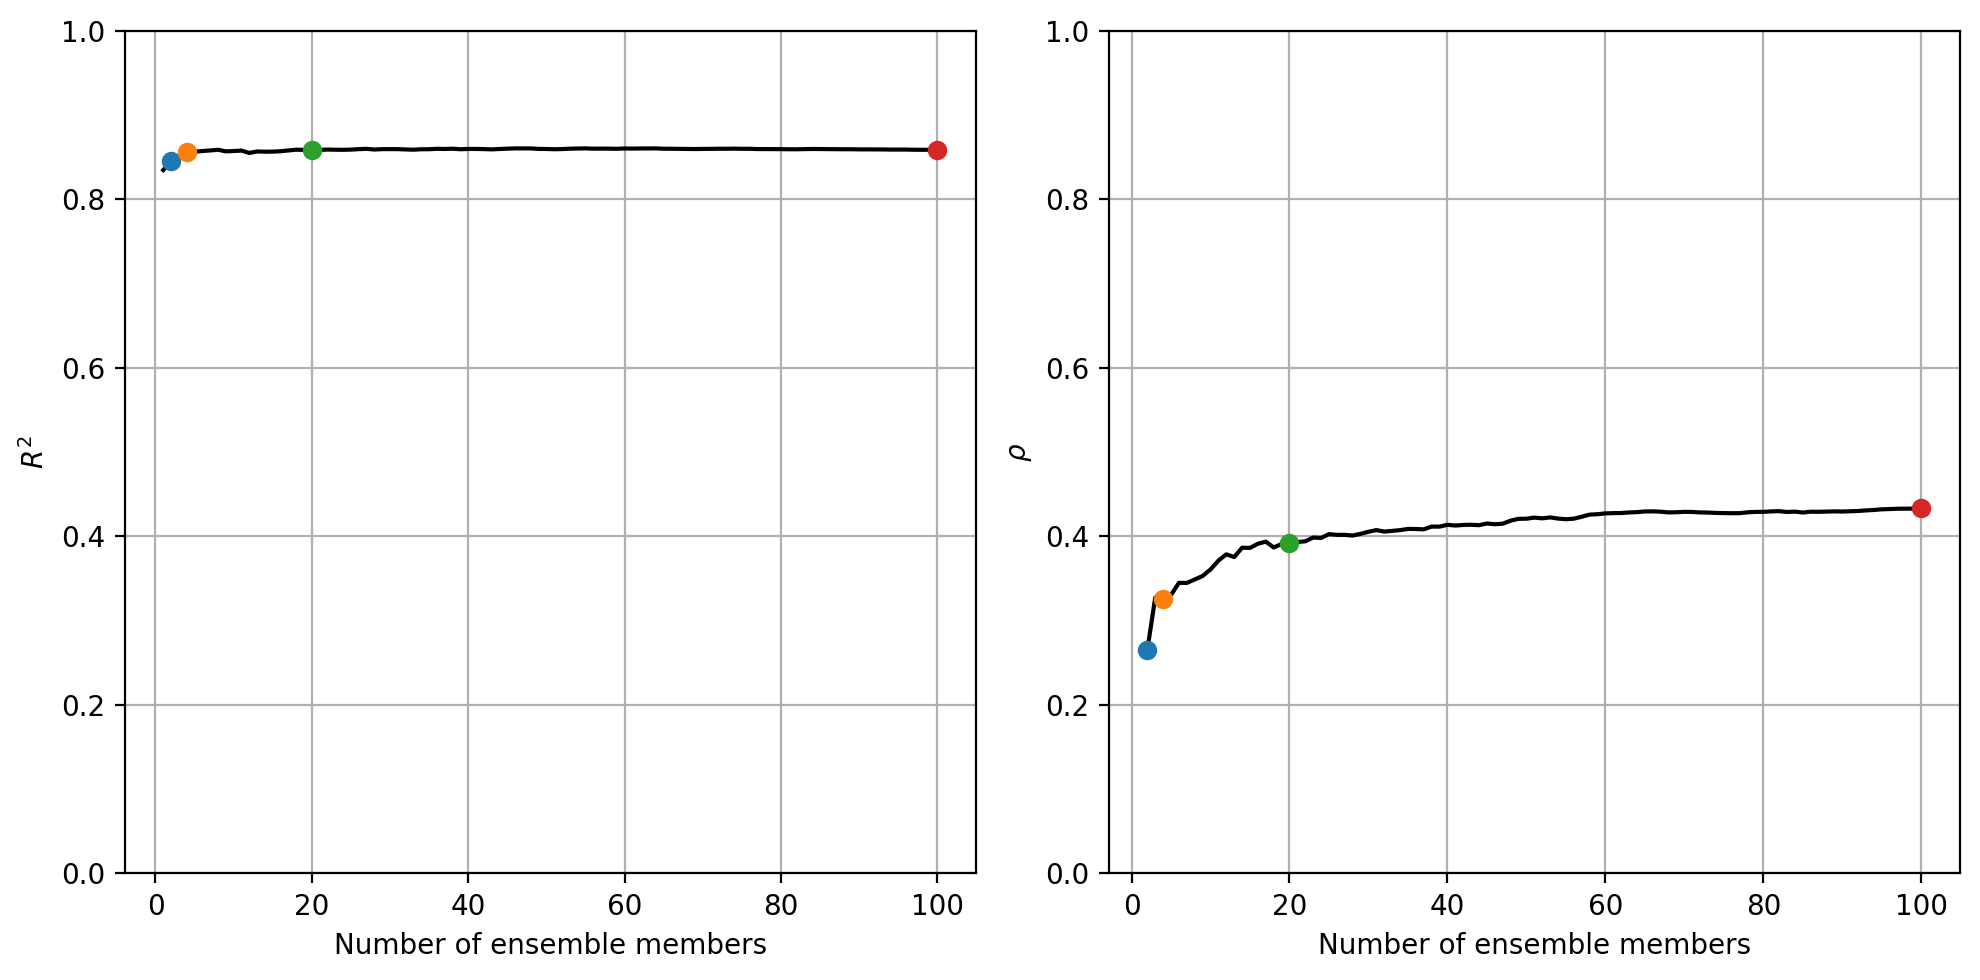

R2 scores gain: 0.02379278044629951
\rho scores gain: 0.1687446412970145


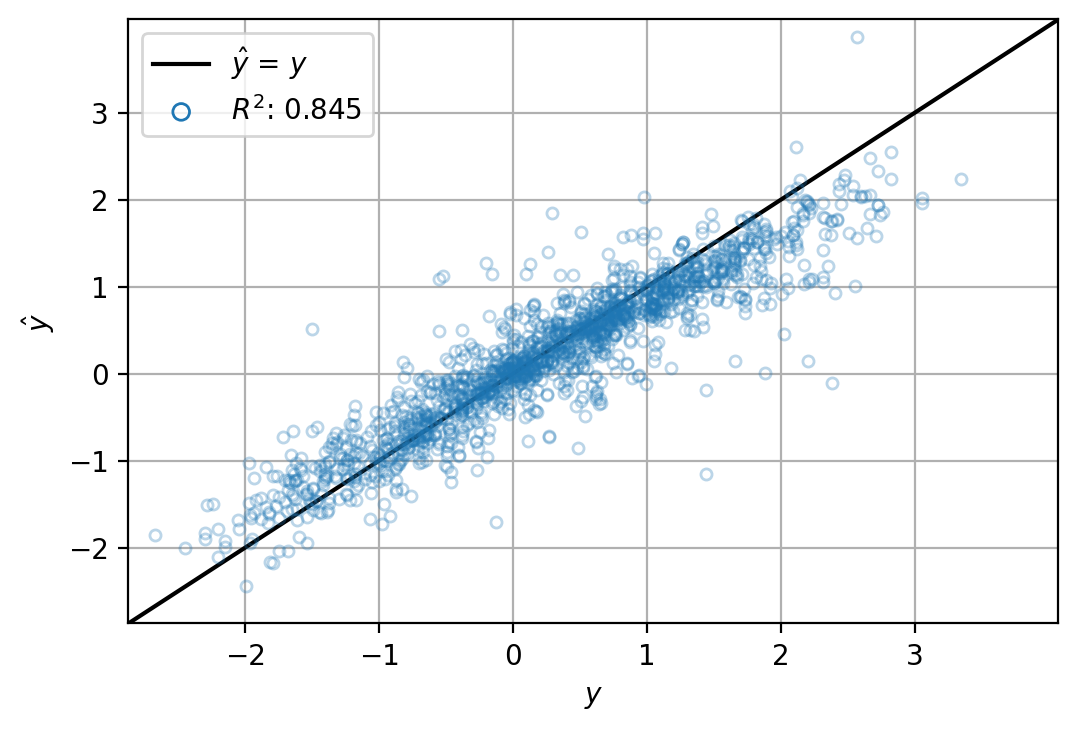

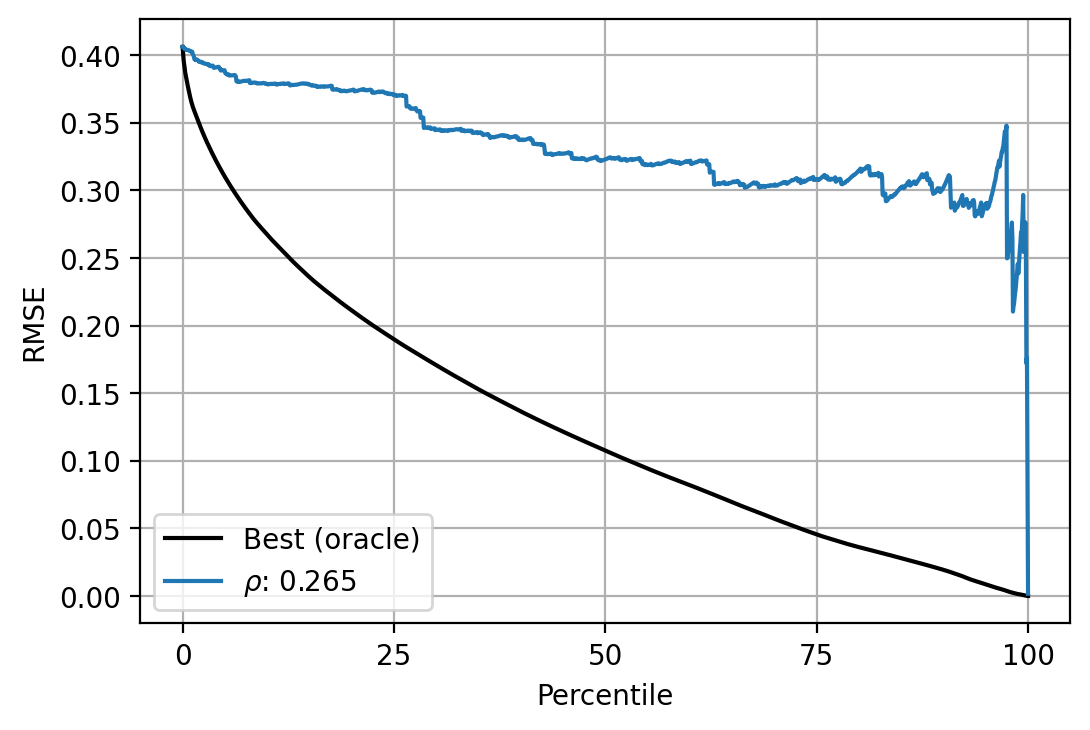

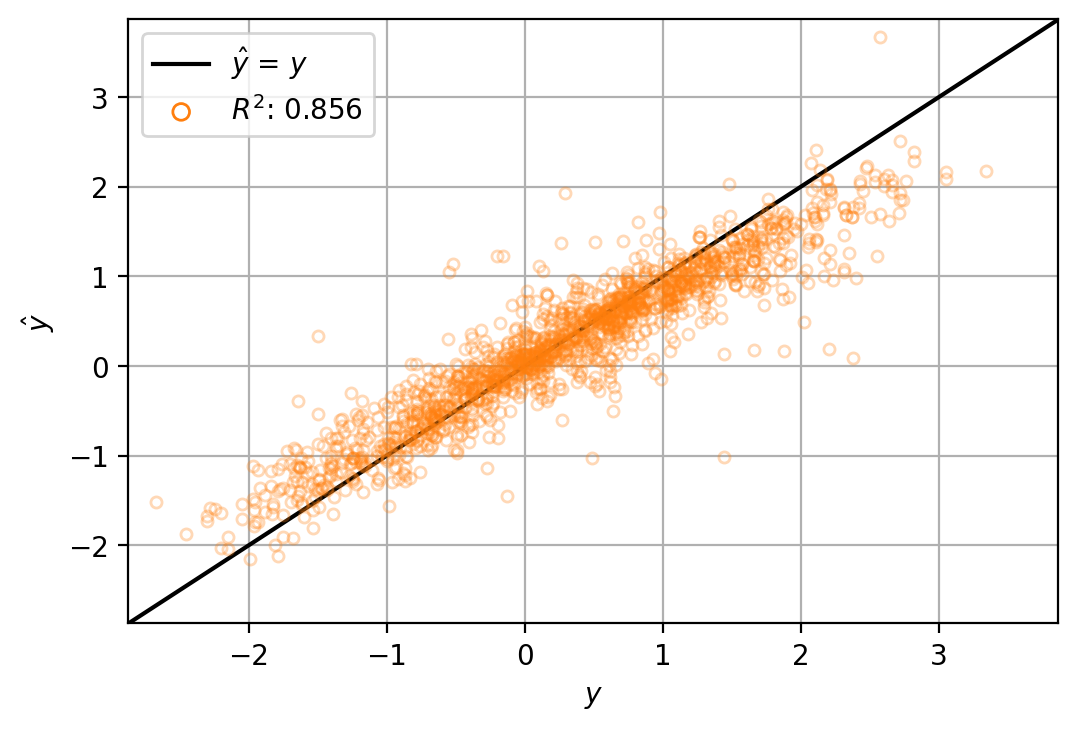

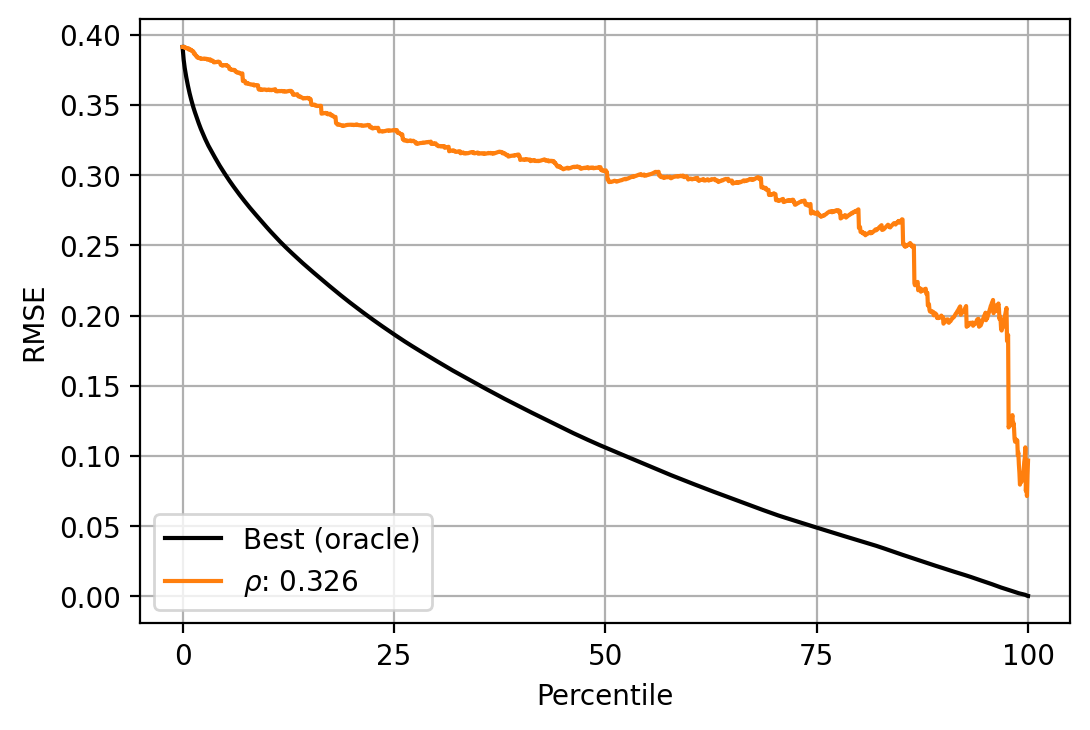

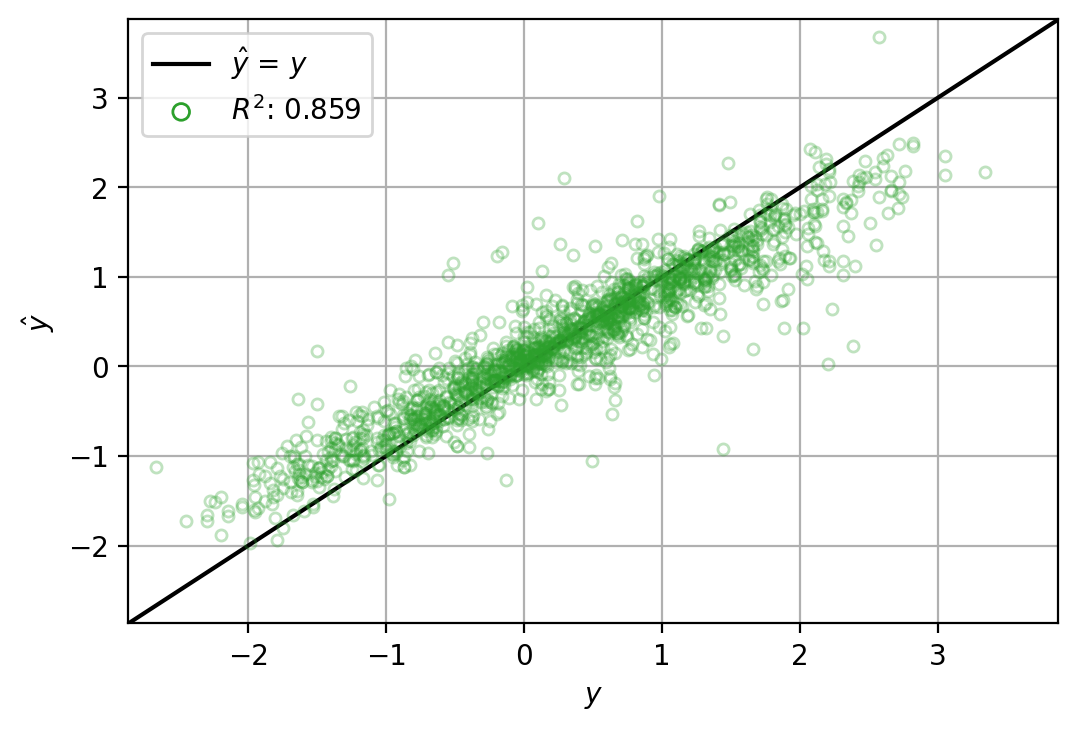

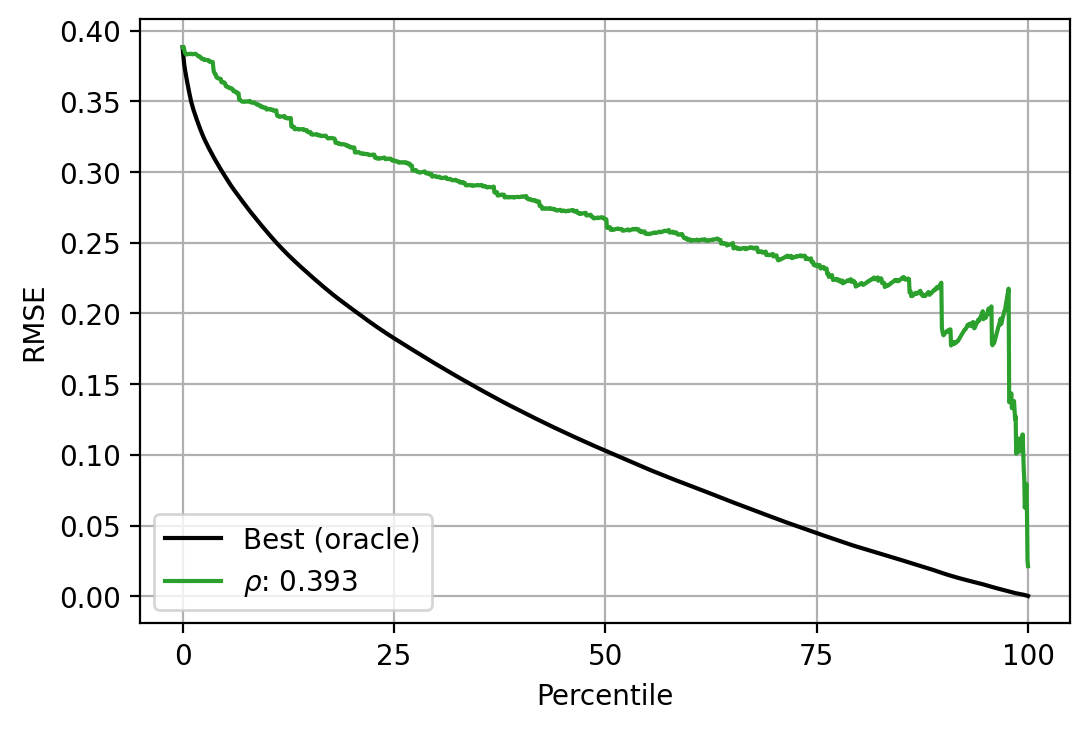

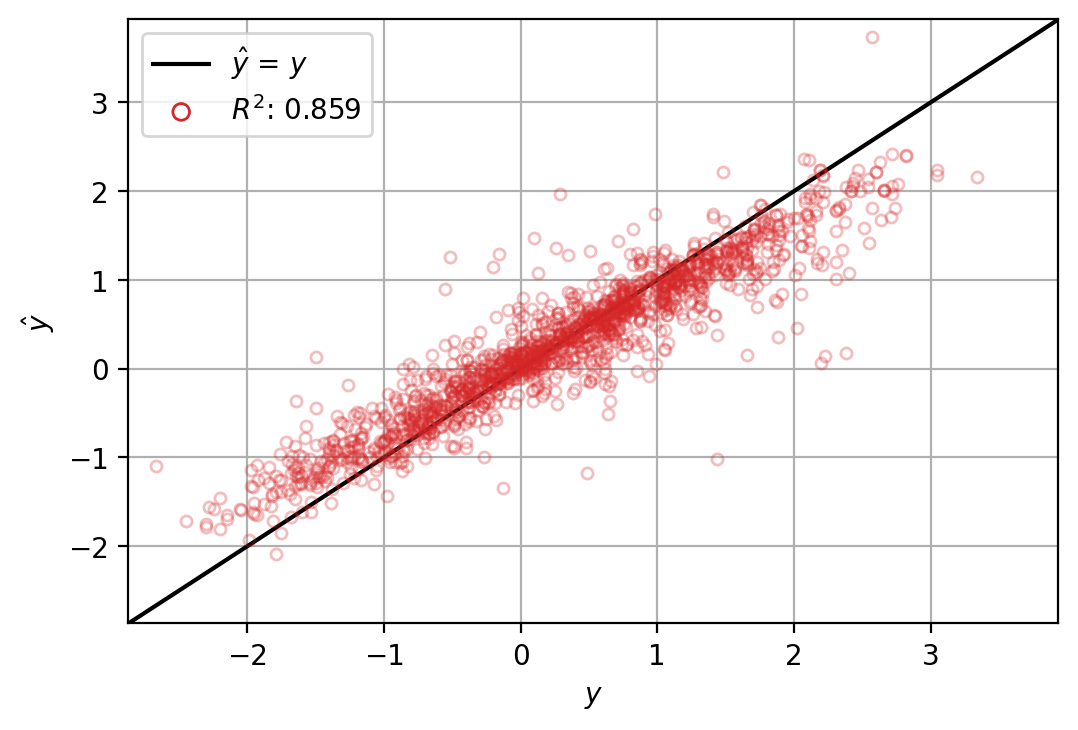

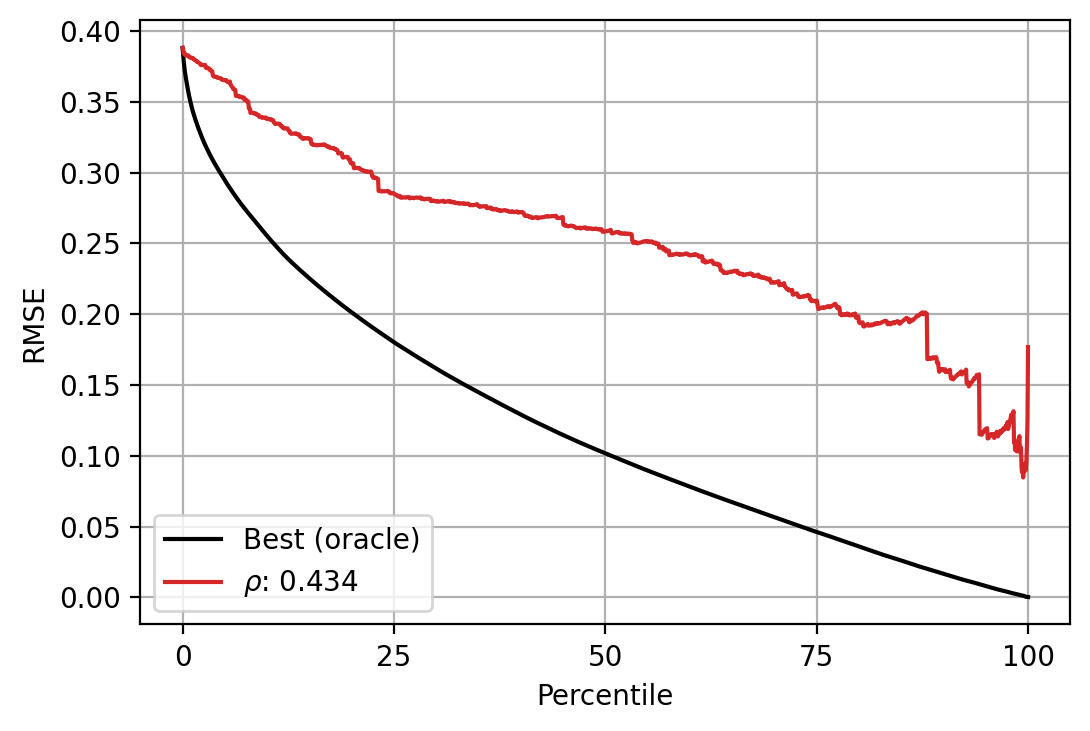

In [5]:
# Must start at 2, otherwise there is no sdev
members_of_choice = [2, 4, 20, 100]

plot_folder = PLOT_FOLDER+'tetrahymena/'
make_folder(plot_folder)

show_all_picks('tetrahymena', 'dropout', 'cddd', members_of_choice, custom_label_range=range(-2, 4), plot_folder=plot_folder)

ESOL 

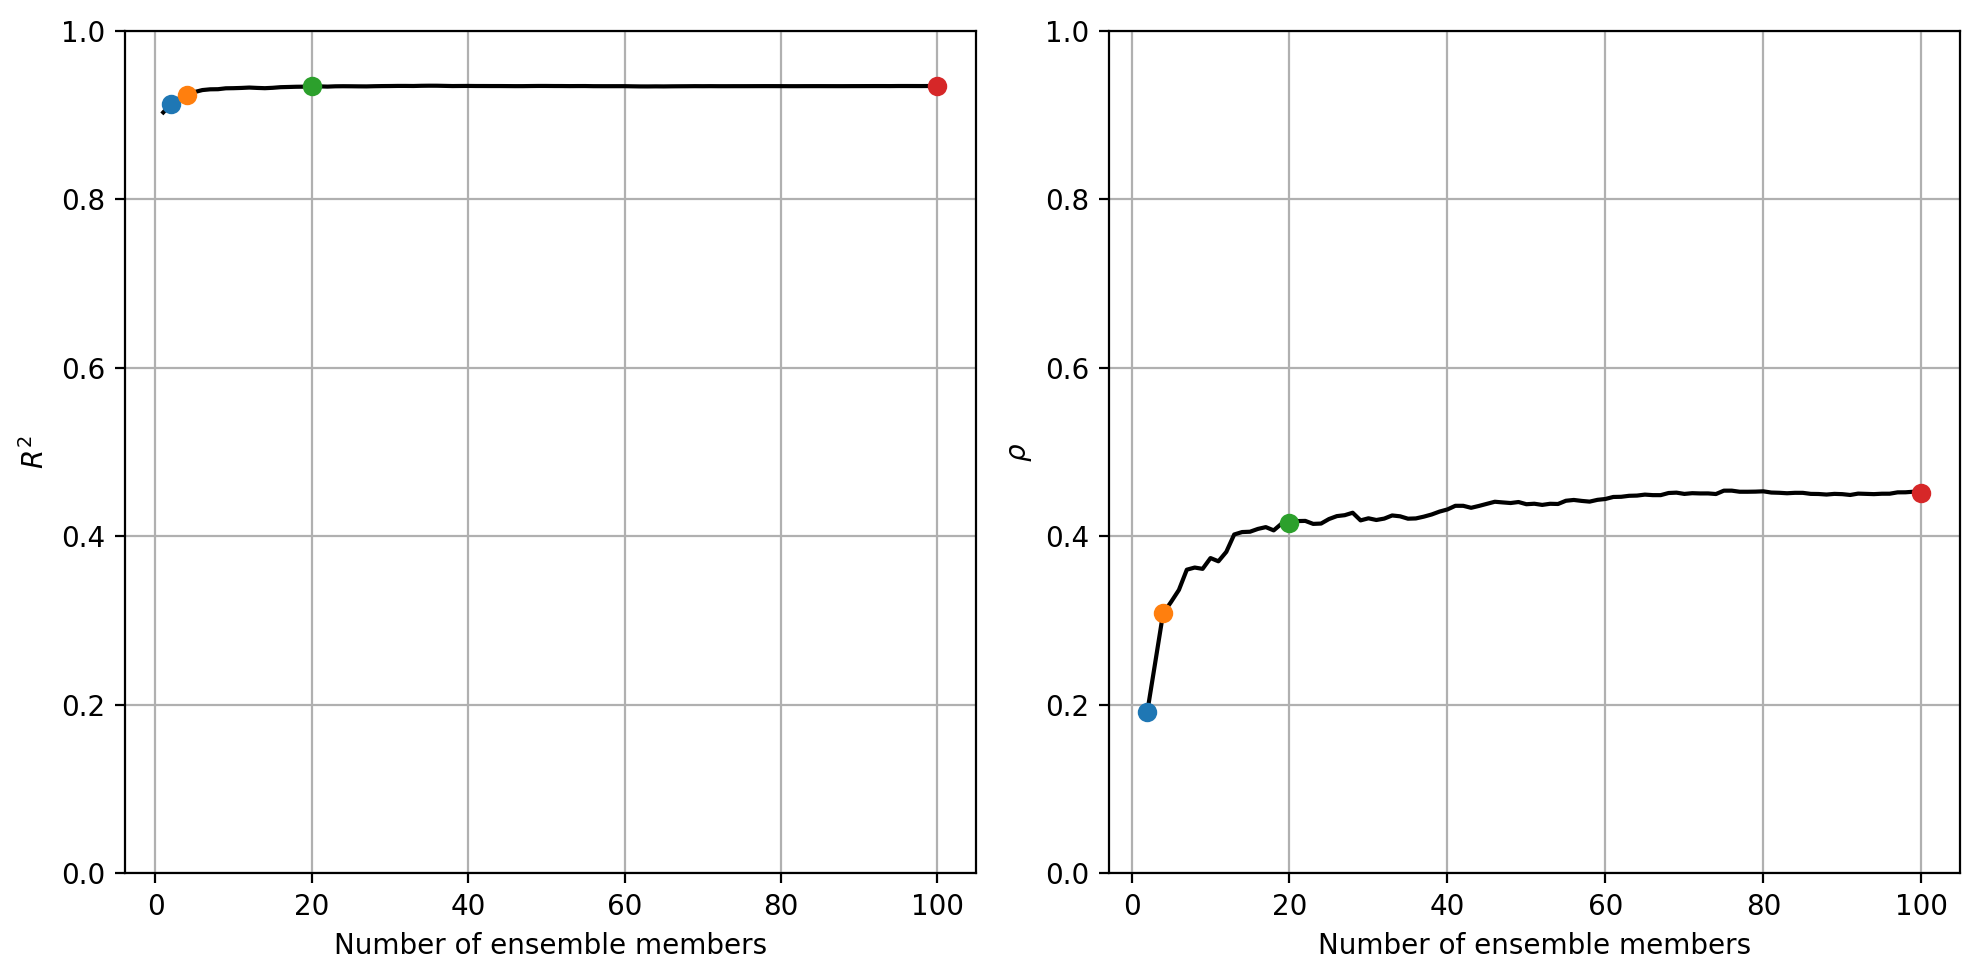

R2 scores gain: 0.03132452939826347
\rho scores gain: 0.2592393896674272


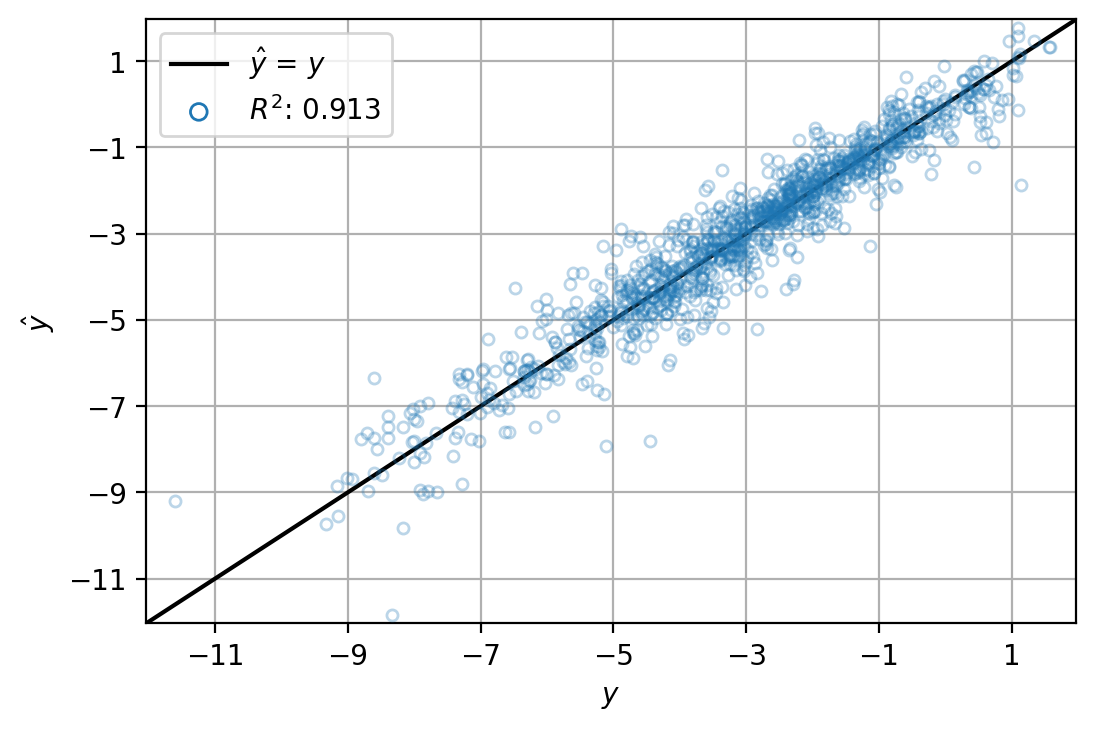

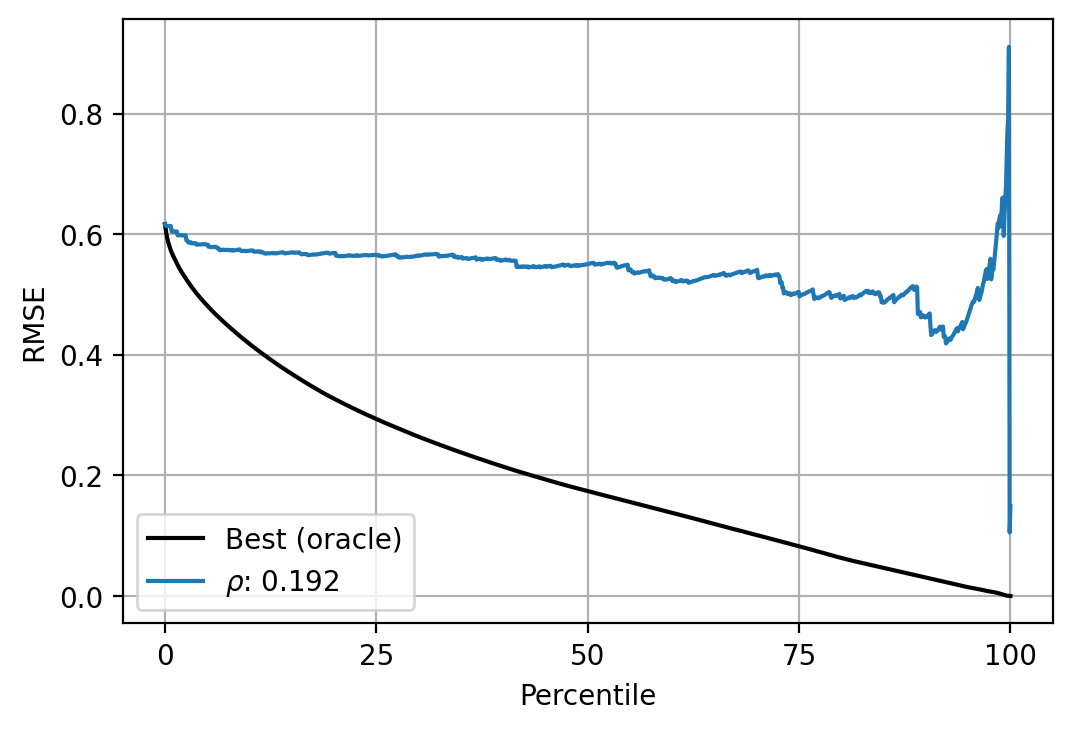

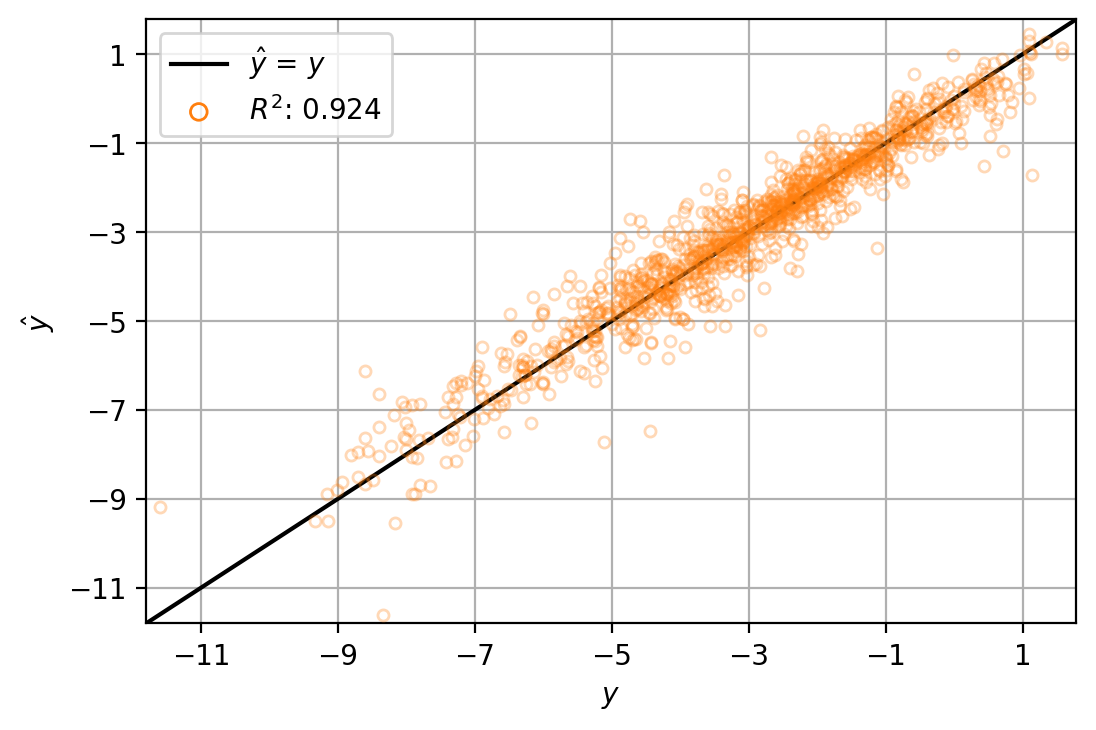

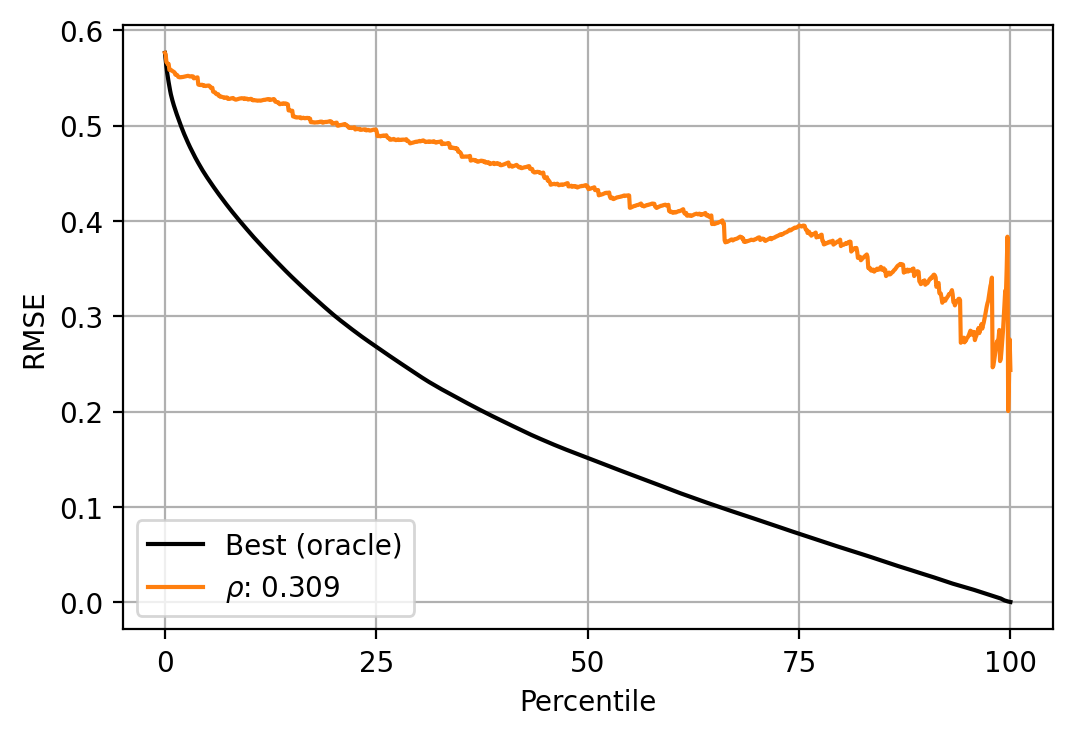

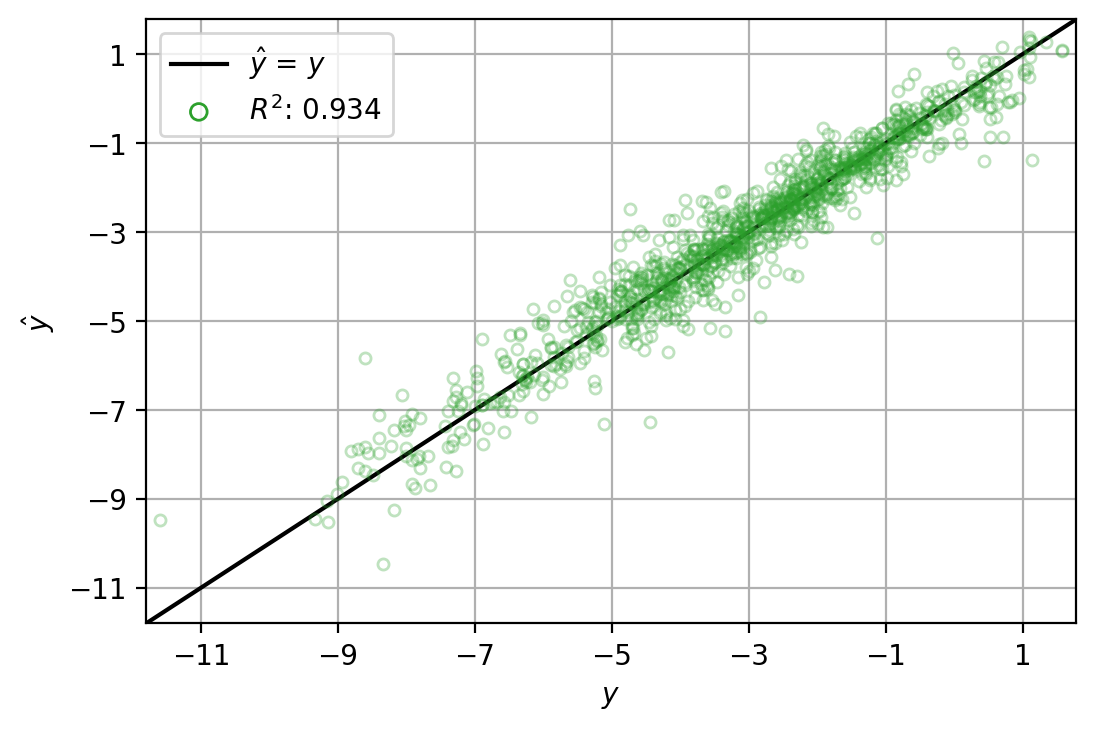

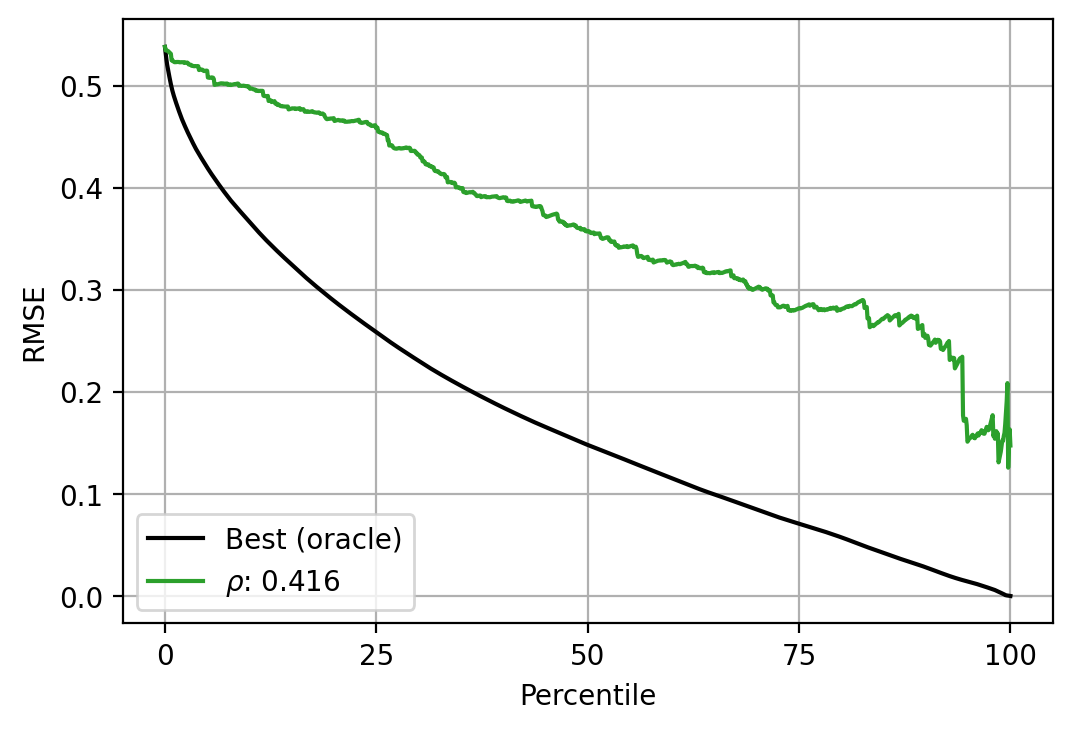

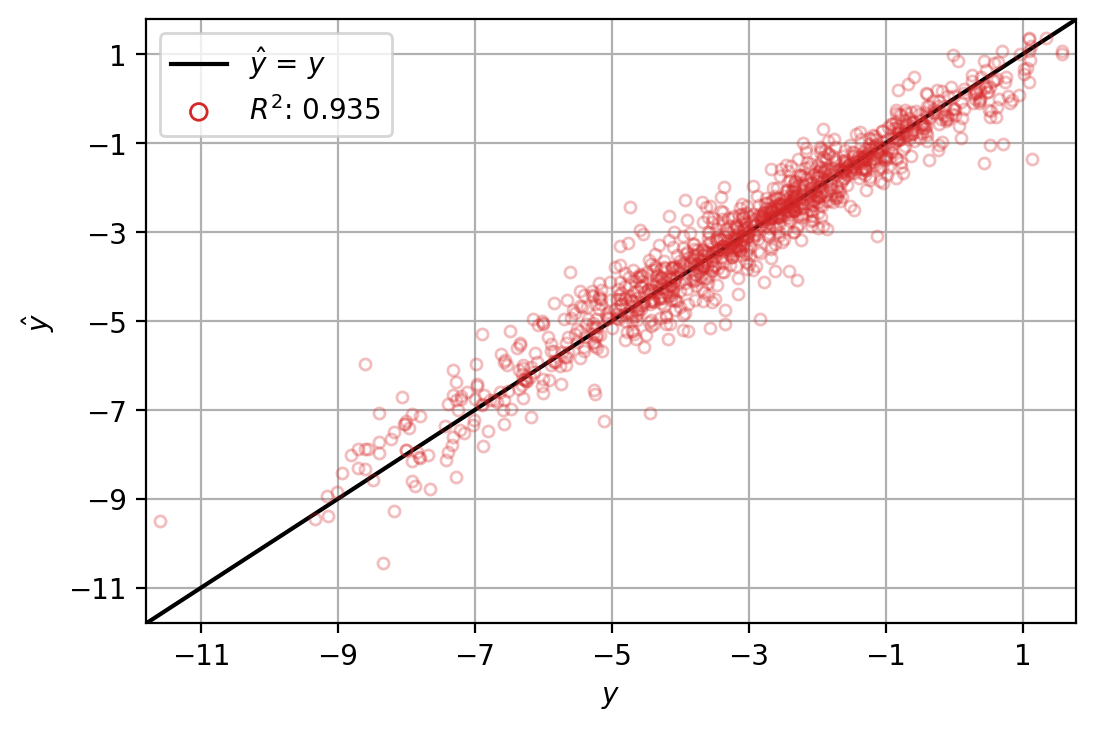

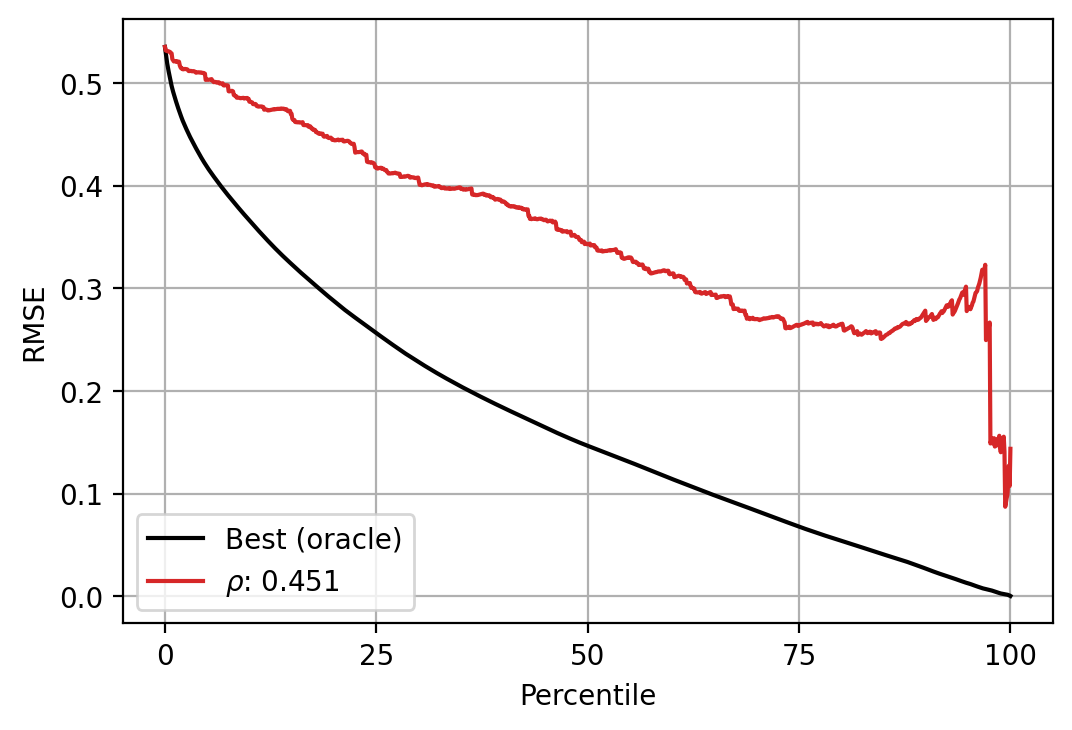

In [6]:
# Must start at 2, otherwise there is no sdev
members_of_choice = [2, 4, 20, 100]

plot_folder = PLOT_FOLDER+'esol/'
make_folder(plot_folder)

show_all_picks('esol', 'shallow', 'cddd', members_of_choice, custom_label_range=range(-11, 2, 2), plot_folder=plot_folder)

R2 scores gain: 0.03132452939826347
\rho scores gain: 0.2592393896674272


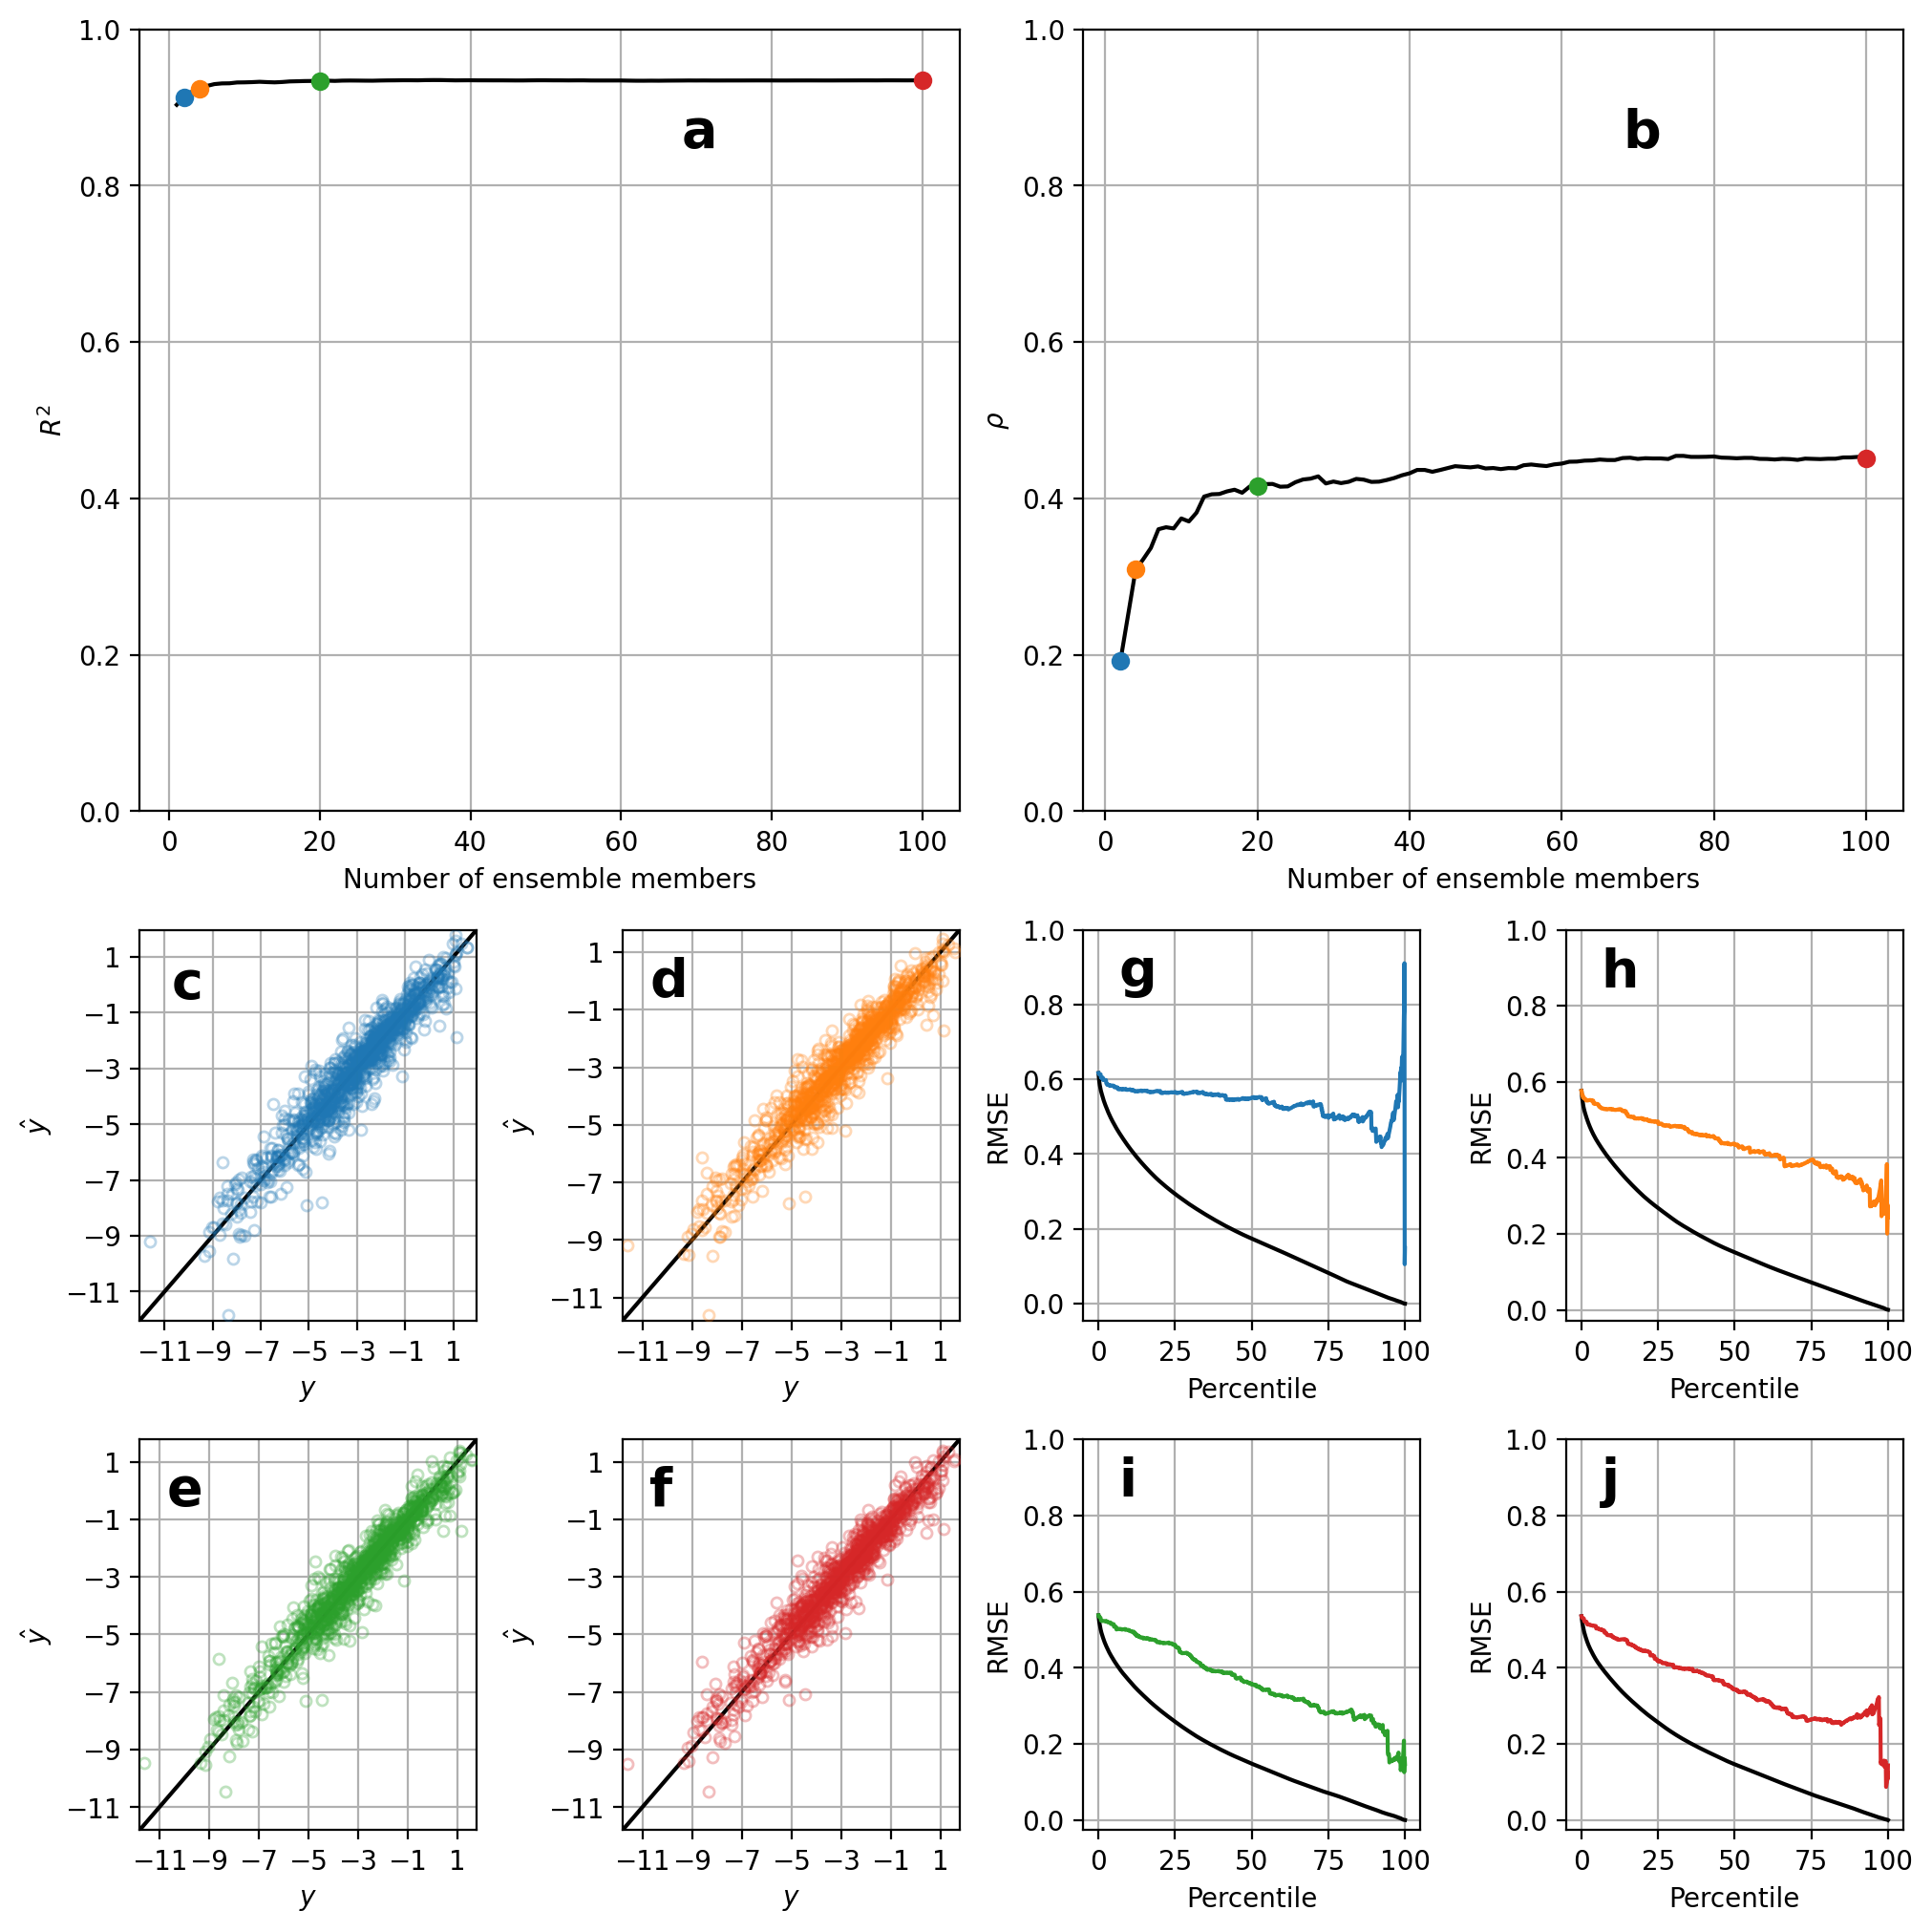

In [7]:
members_of_choice = [2, 4, 20, 100]
pre_custom_rmse_range = range(0, 11, 2)
custom_rmse_range = [val/10 for val in pre_custom_rmse_range]
plot_folder = PLOT_FOLDER+'esol/'
show_all_picks_with_details('esol', 'shallow', 'cddd', members_of_choice, 
                            custom_label_range=range(-11, 2, 2), 
                            custom_rmse_range=custom_rmse_range, 
                            plot_folder=plot_folder,
                            cumr2_text='a', cumrho_text='b',
                            cumr2_text_loc=[68, .85], cumrho_text_loc=[68, .85],
                            member_r2_texts=['c', 'd', 'e', 'f'], member_rho_texts=['g', 'h', 'i', 'j'],
                            member_r2_textlocs=[-10.7, -.5], member_rho_textlocs=[6.5, .85])

P06401

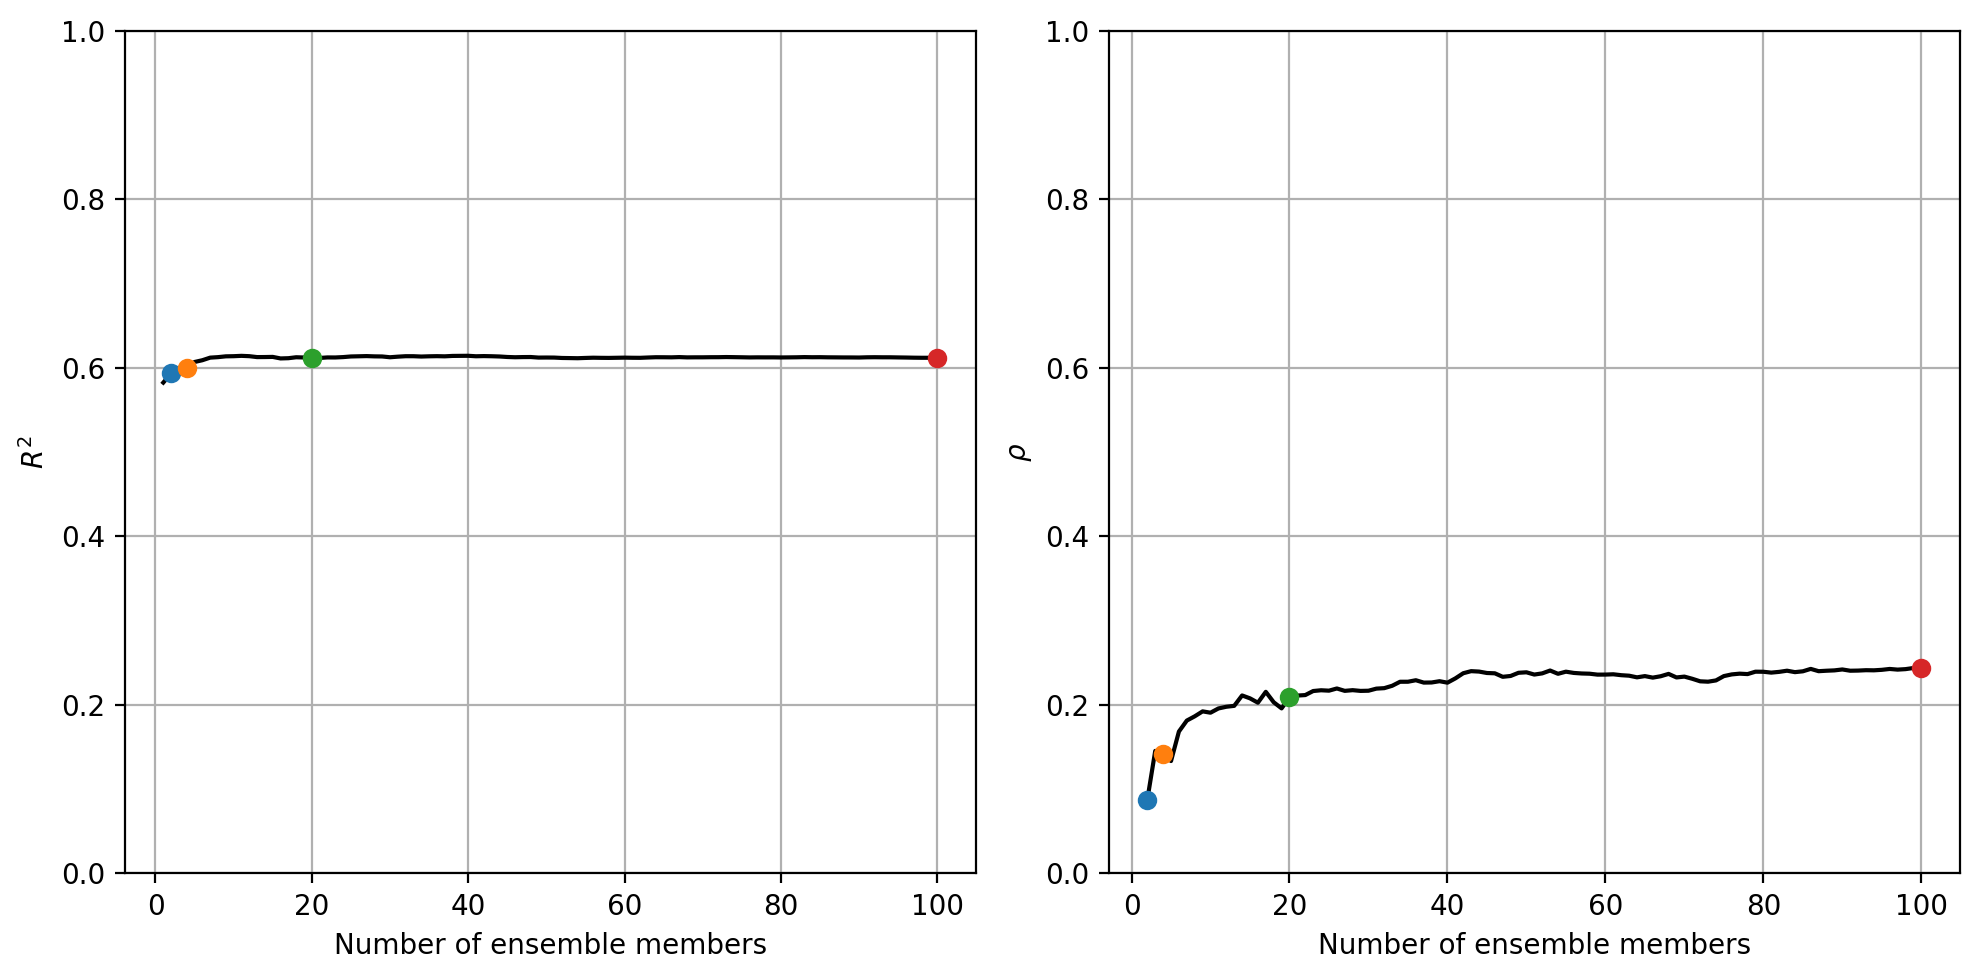

R2 scores gain: 0.02956963657311029
\rho scores gain: 0.15630297609480087


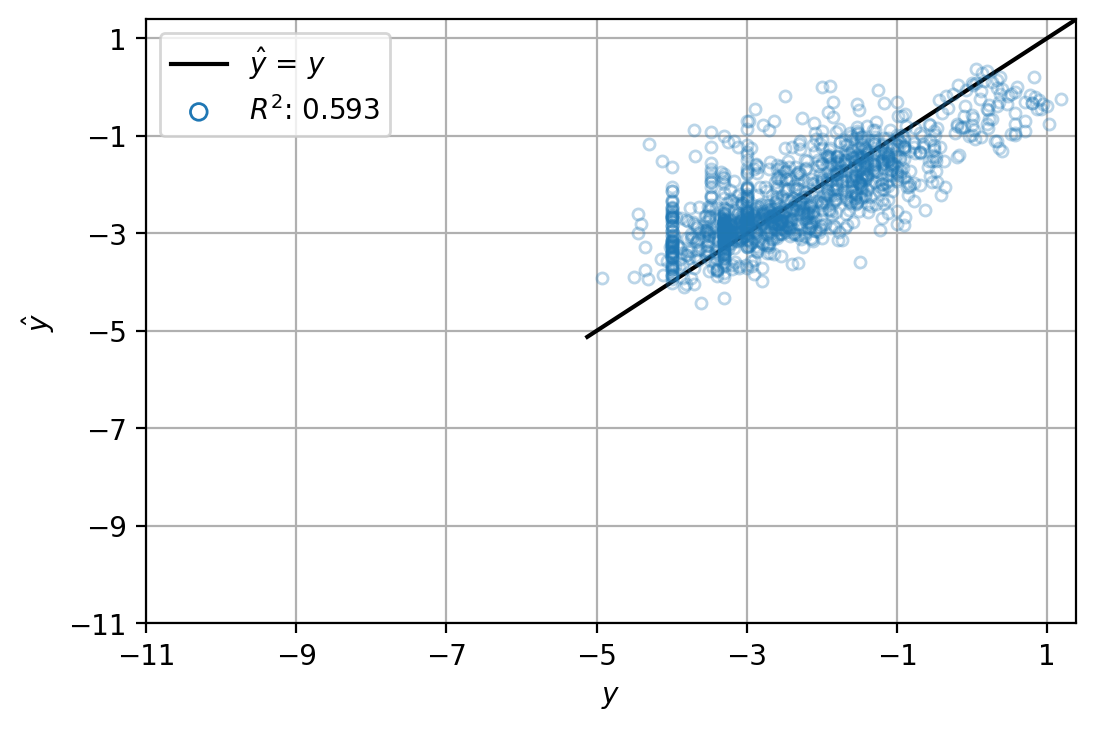

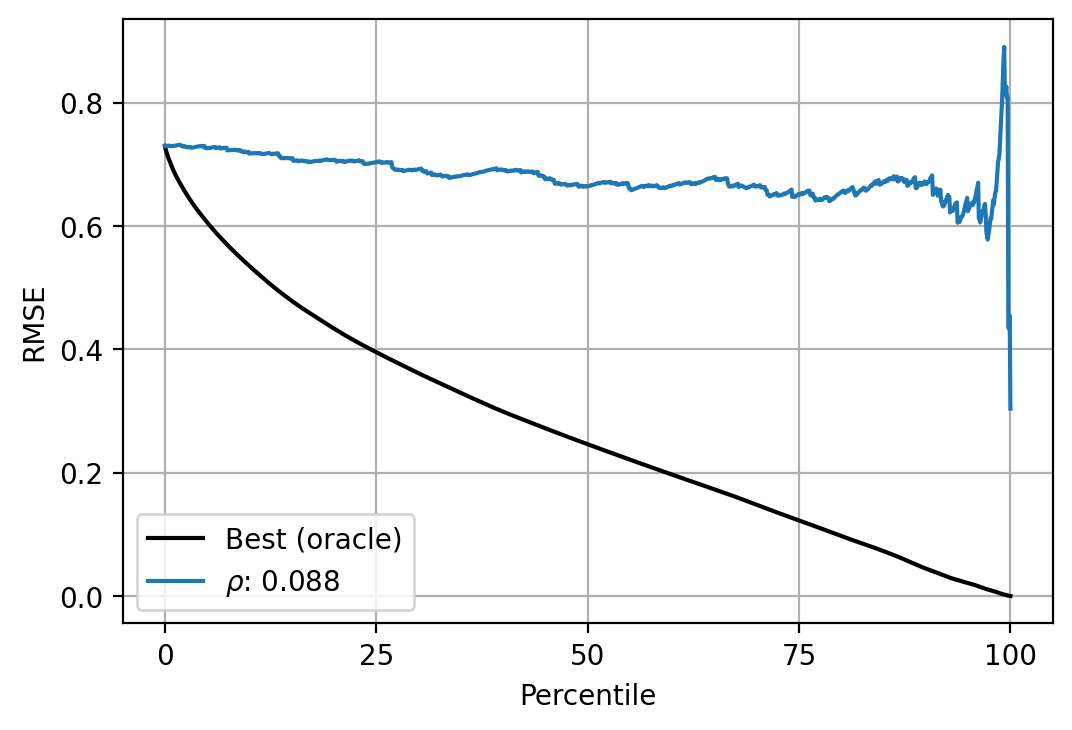

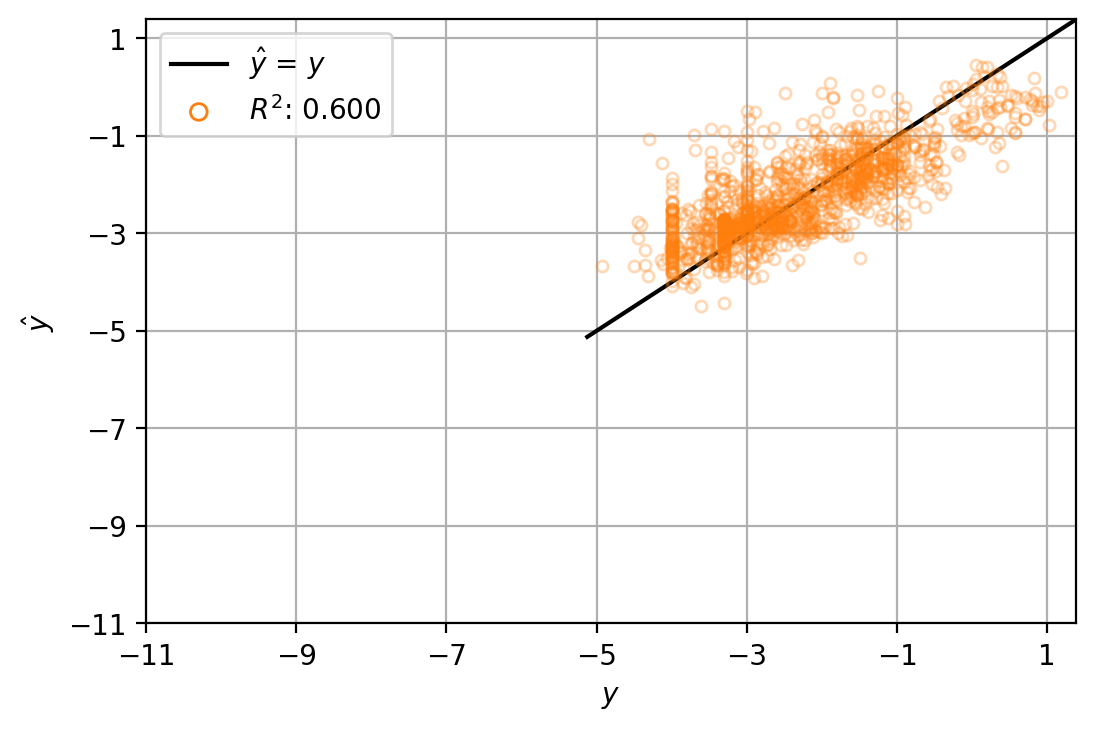

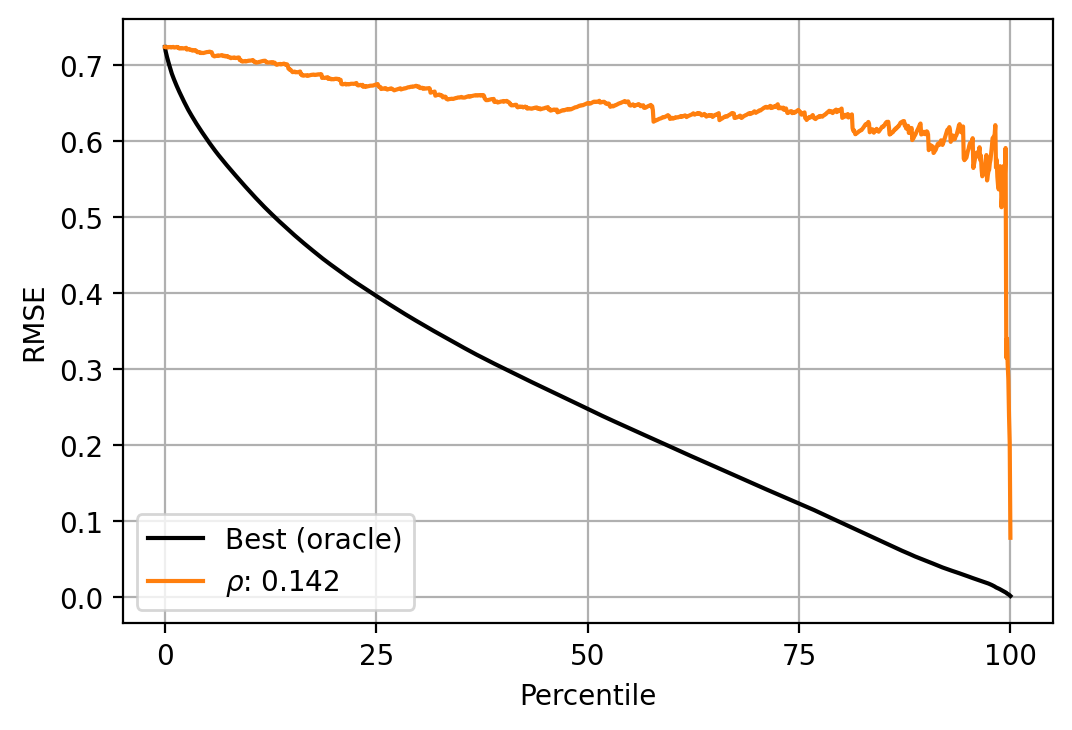

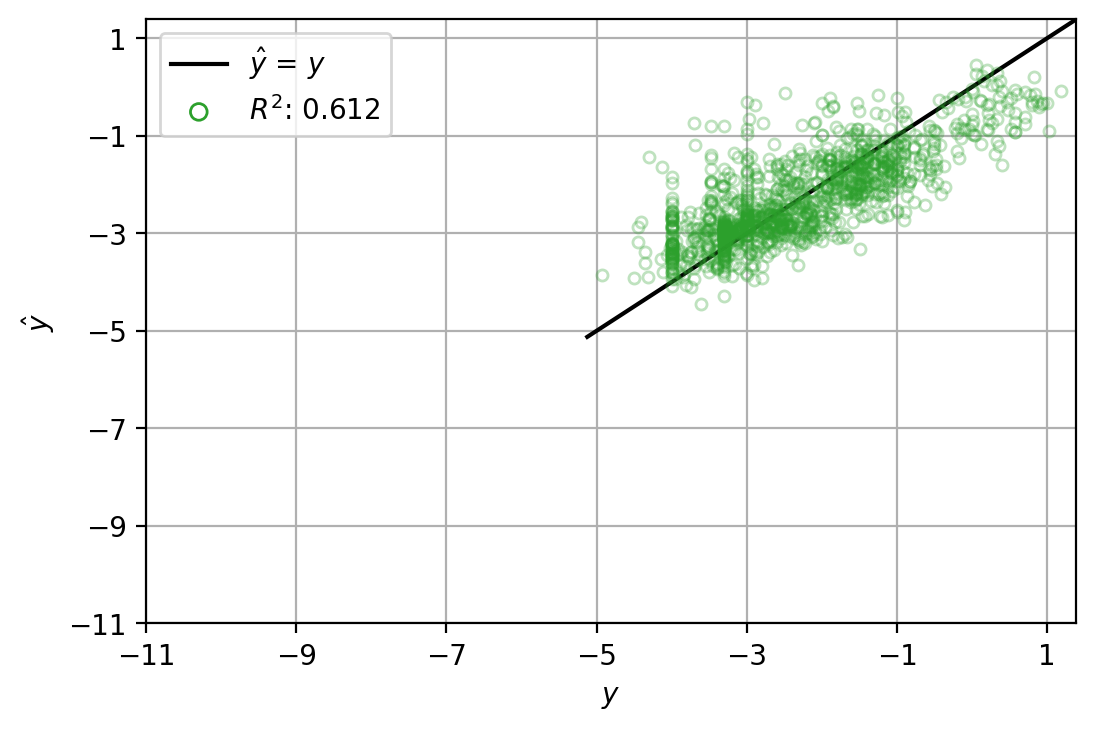

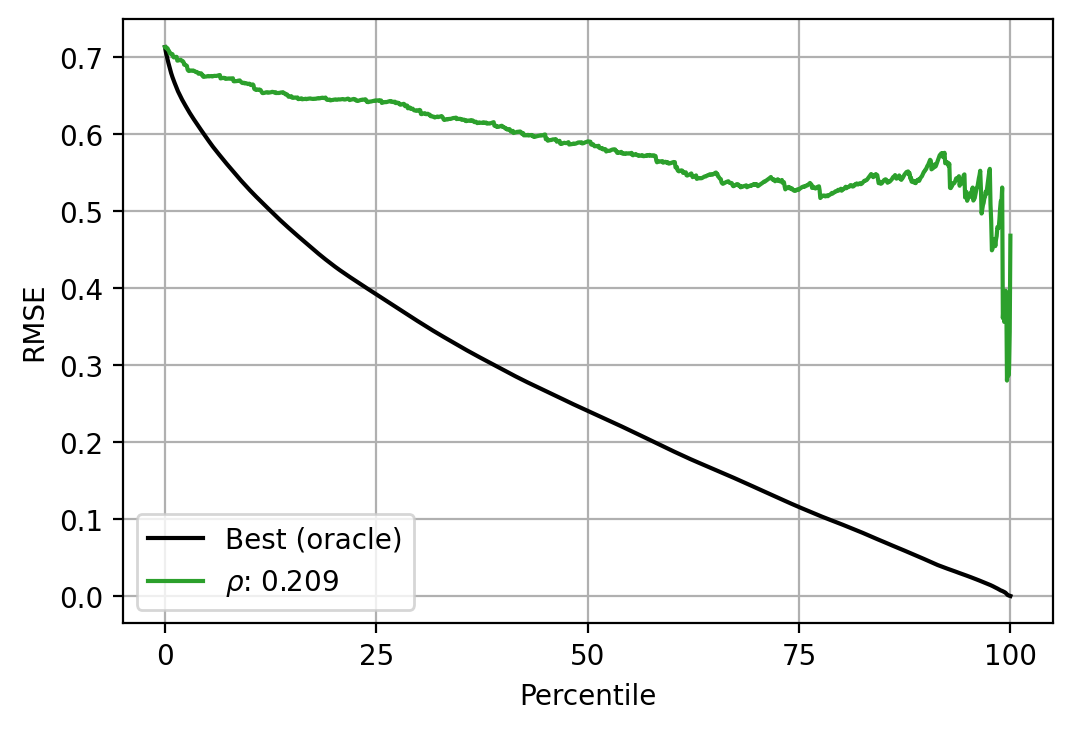

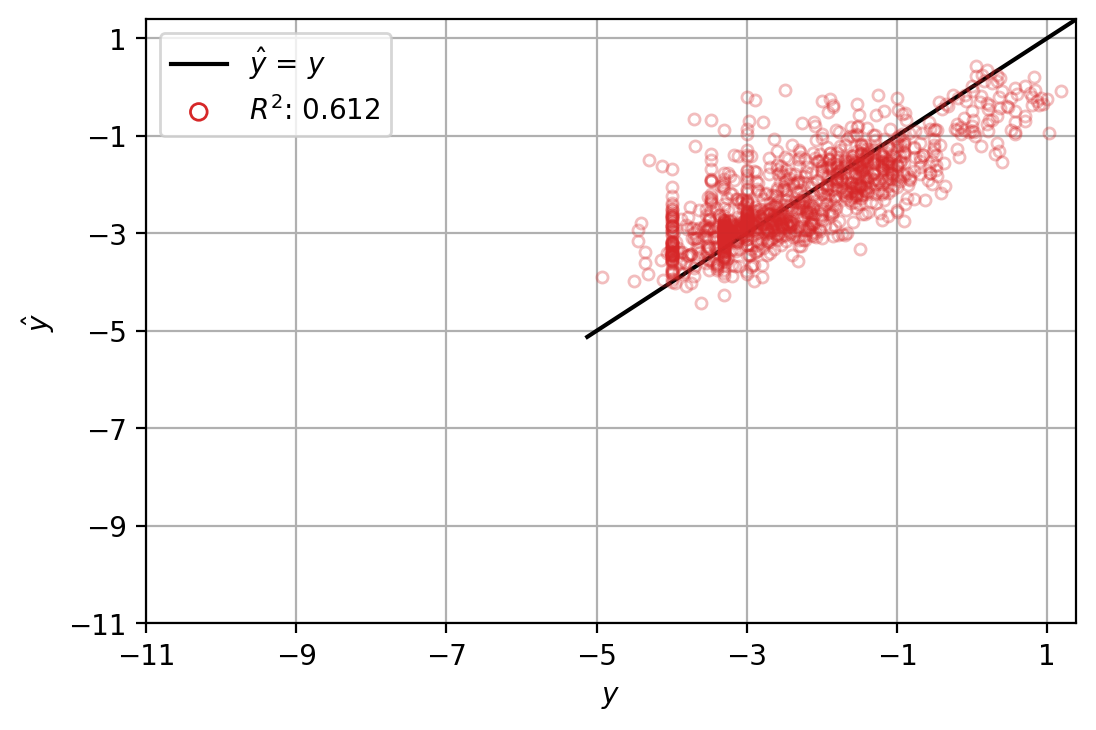

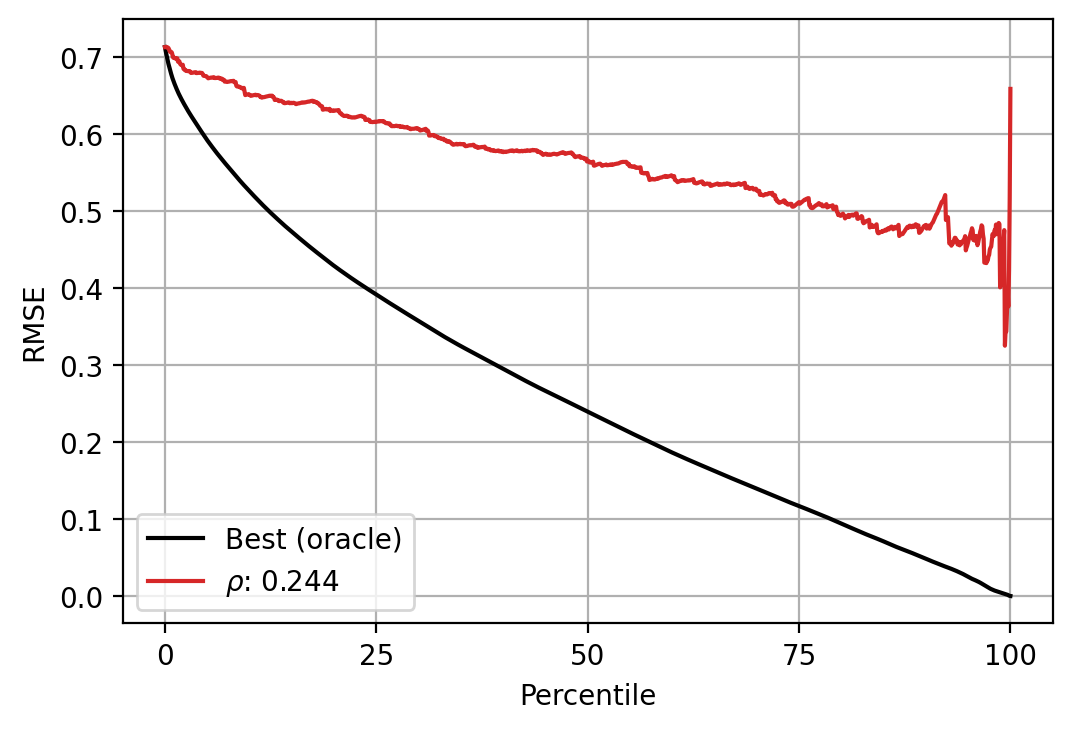

In [8]:
# Must start at 2, otherwise there is no sdev
members_of_choice = [2, 4, 20, 100]

plot_folder = PLOT_FOLDER+'P06401/'
make_folder(plot_folder)

show_all_picks('P06401', 'shallow', 'maccs', members_of_choice, custom_label_range=range(-11, 2, 2), plot_folder=plot_folder)

P12931

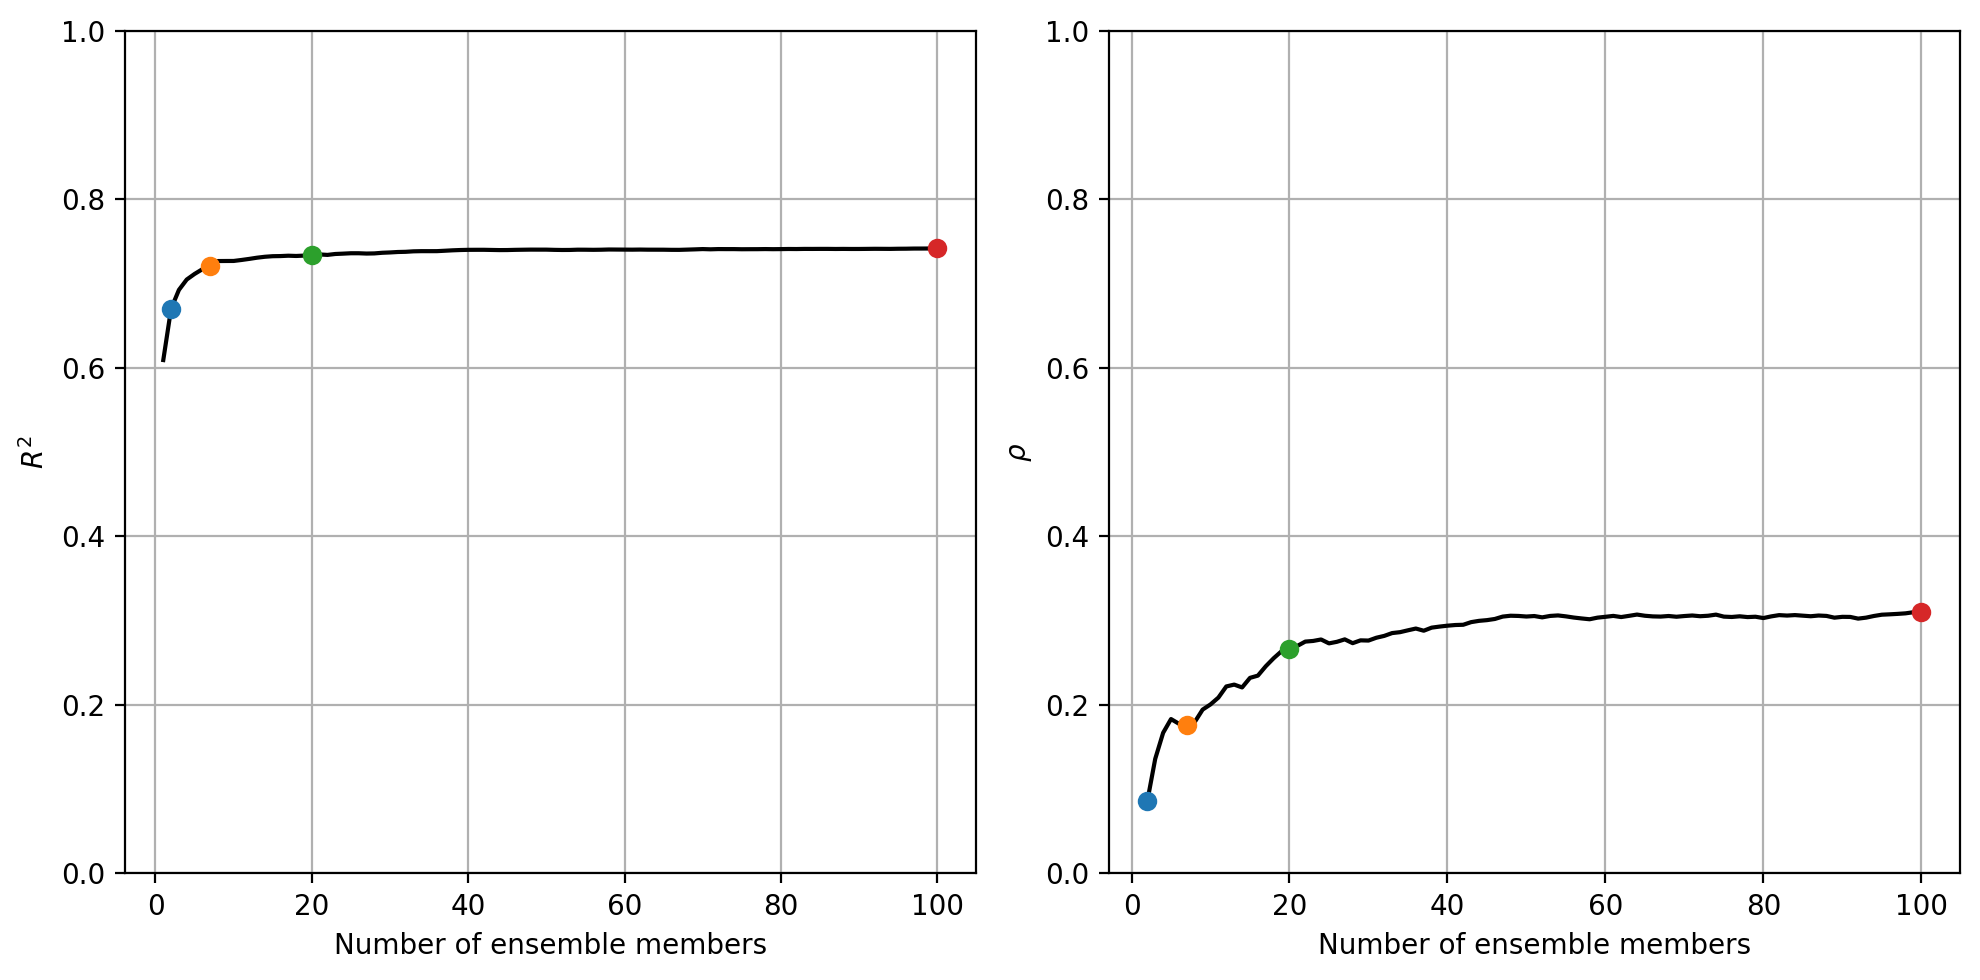

R2 scores gain: 0.13242276034204759
\rho scores gain: 0.224012256137692


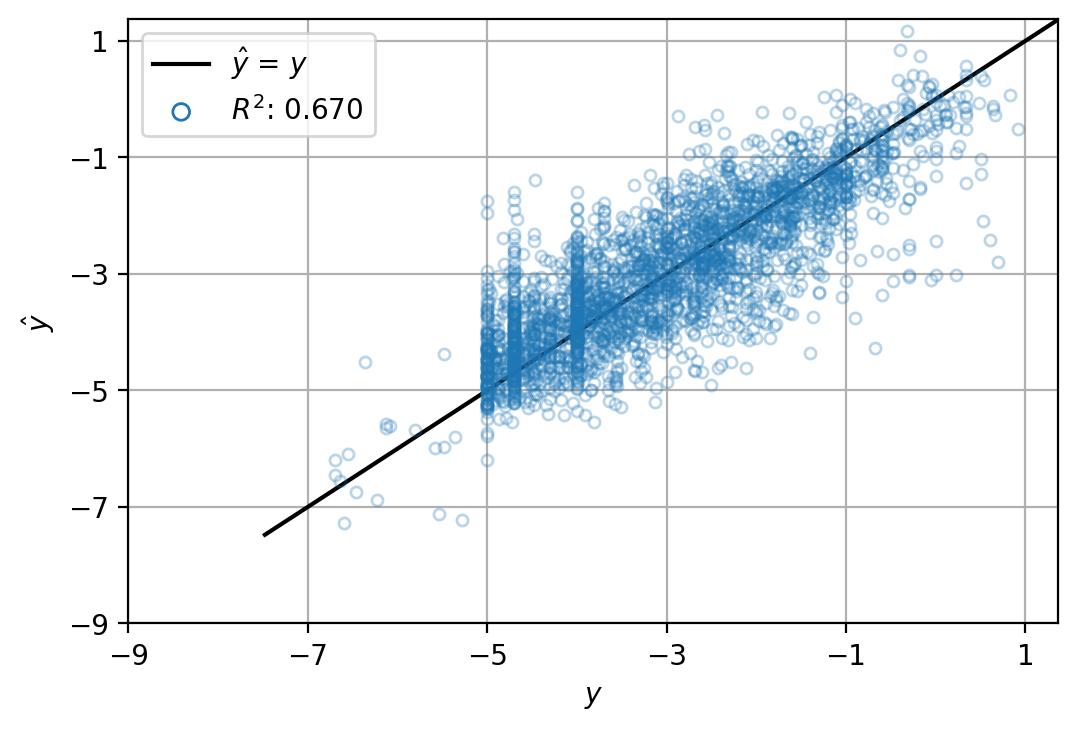

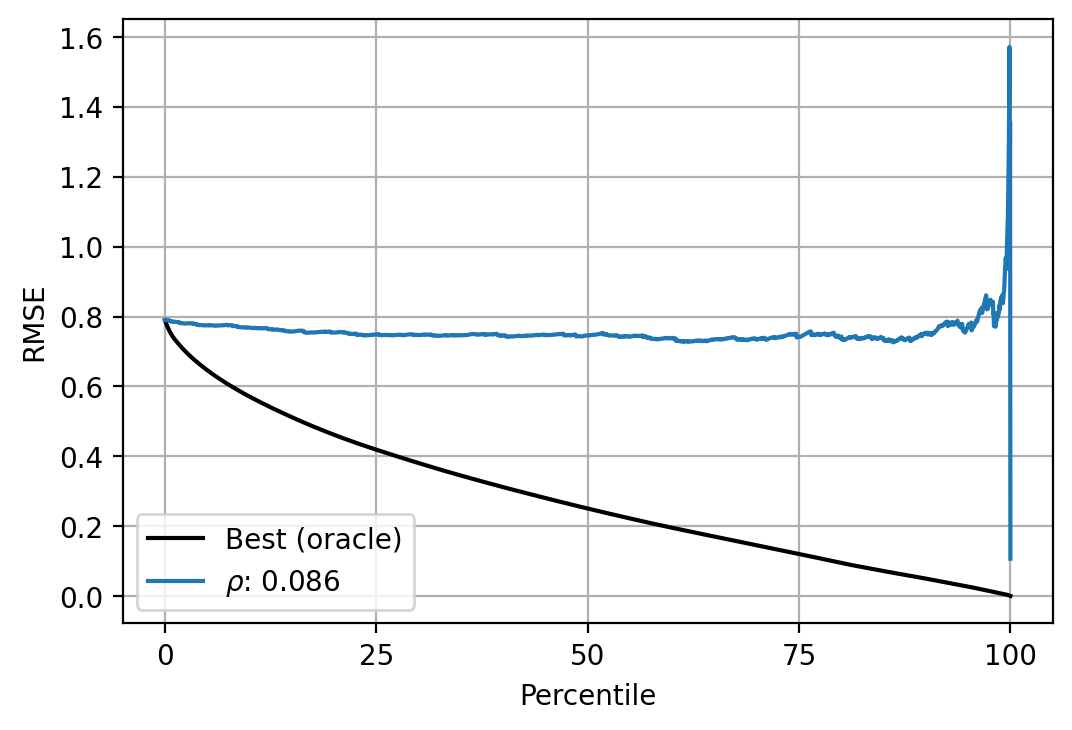

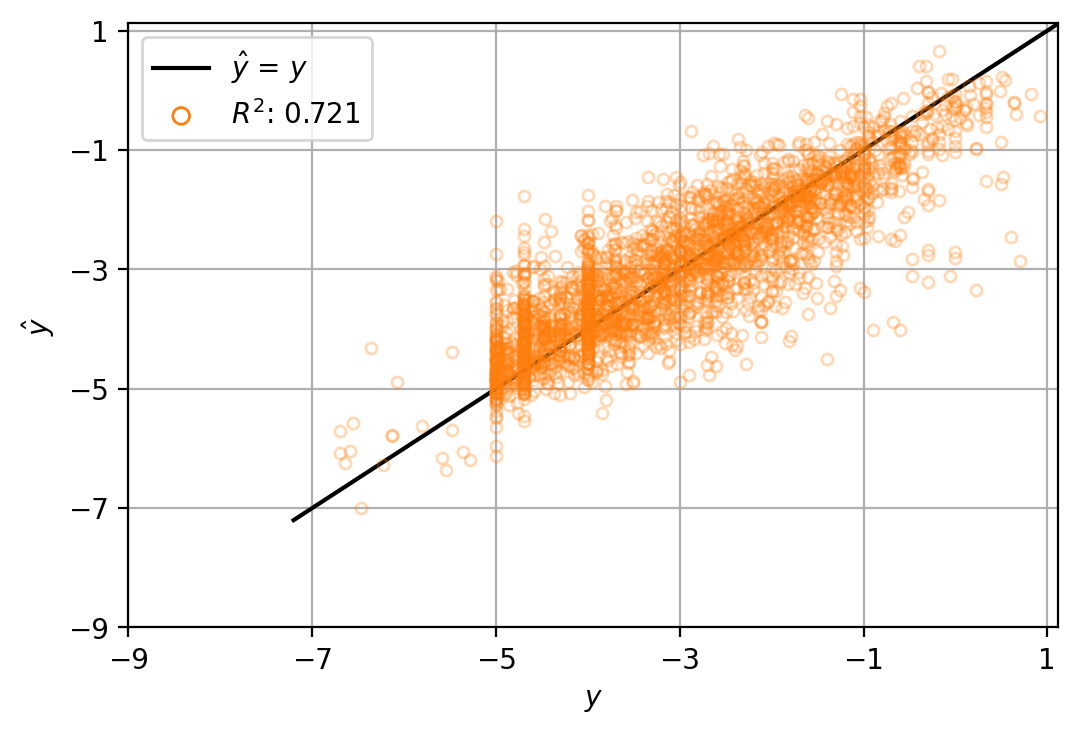

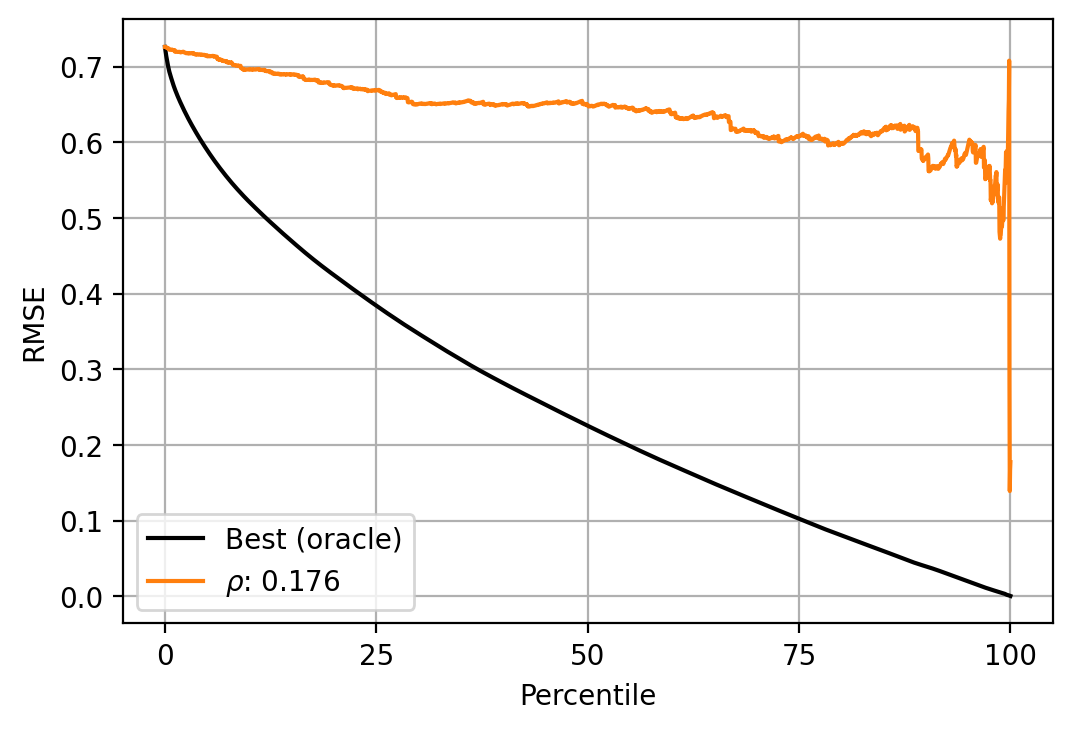

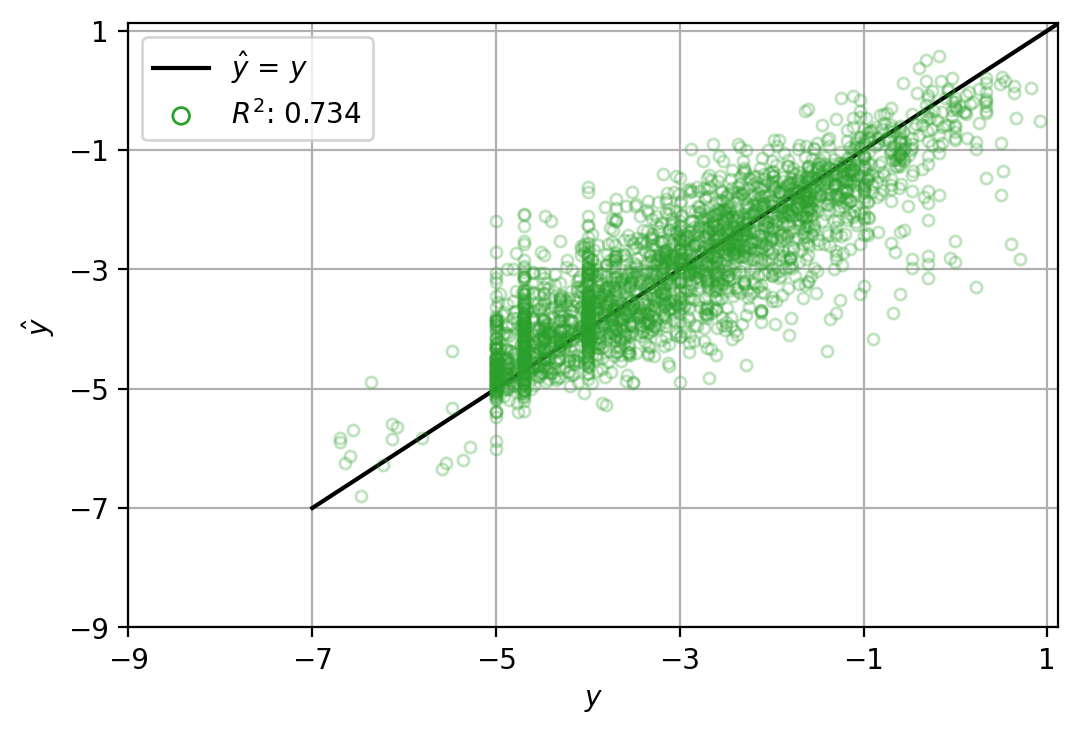

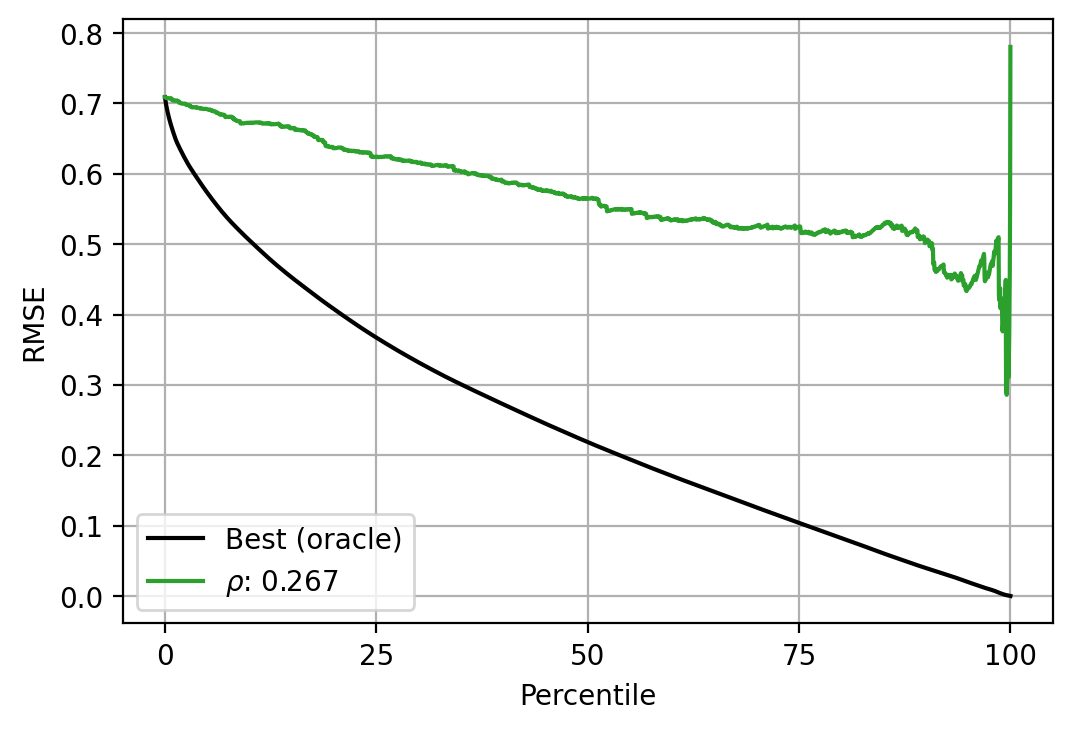

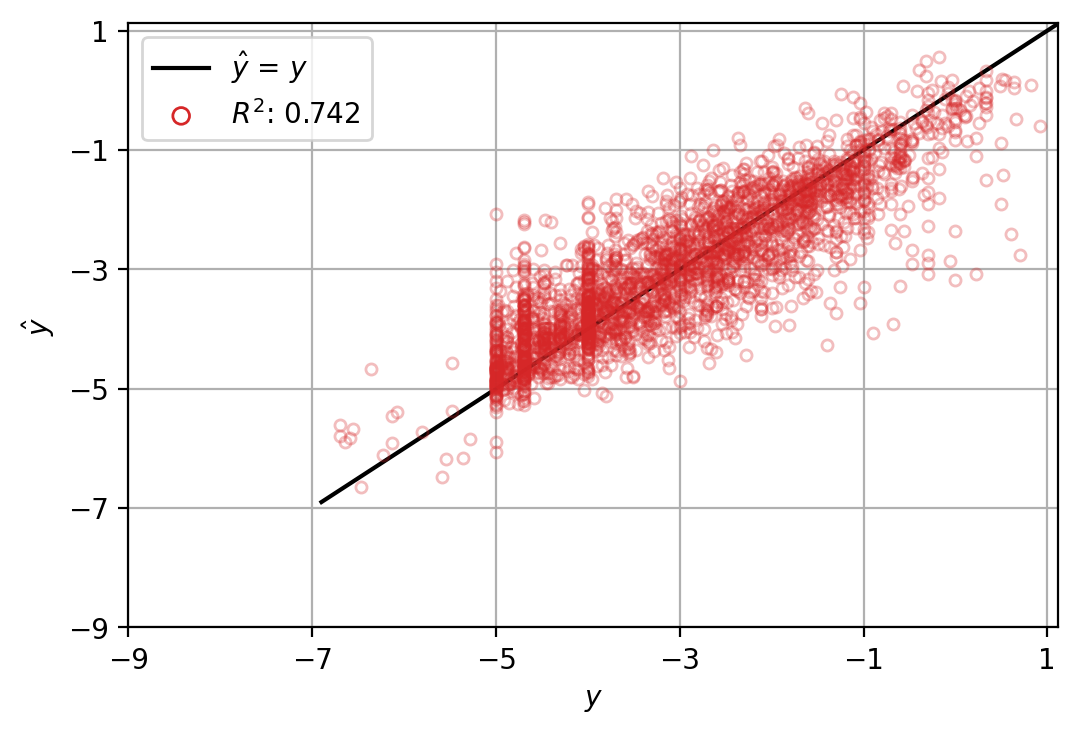

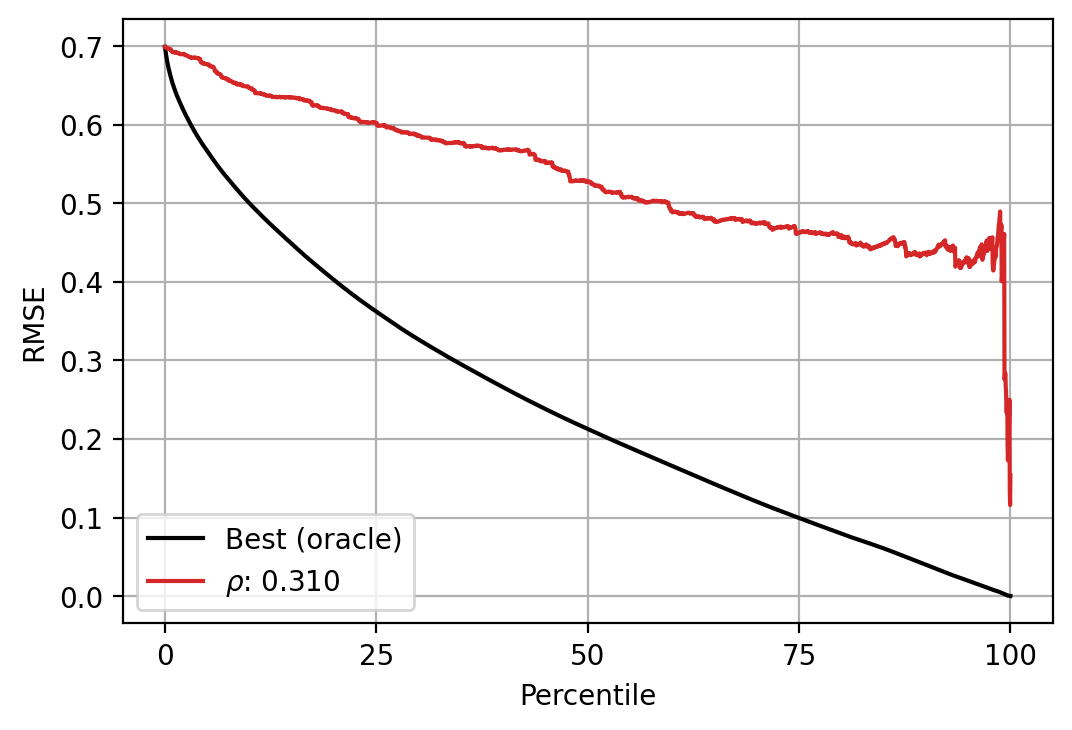

In [9]:
# Must start at 2, otherwise there is no sdev
members_of_choice = [2, 7, 20, 100]

plot_folder = PLOT_FOLDER+'P12931/'
make_folder(plot_folder)

show_all_picks('P12931', 'shallow', 'cddd', members_of_choice, custom_label_range=range(-9, 3, 2), plot_folder=plot_folder)

#### Separate plots for presentation

Scatter

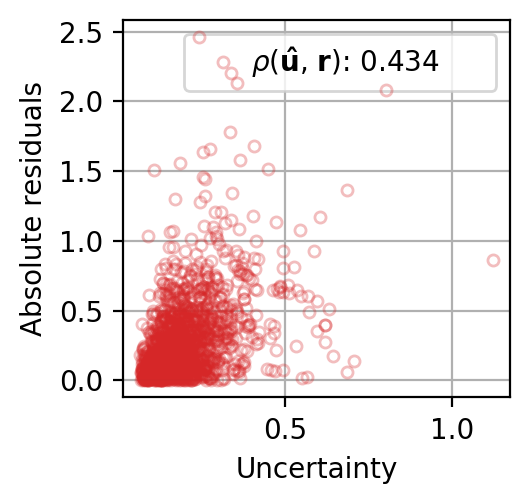

In [10]:
single_tables = load_results_file('tetrahymena', 'dropout', 'cddd')
y = load_true('tetrahymena')
member_i = 100

mean, uqs, y_clean = preds_and_uqs_until_member(single_tables, y, 99, clean=True)
resd = mean['pred'] - y['y']

plot_scatter(
    resd.abs(),
    uqs,
    color_i=3,
    custom_label=r'$\rho$' + r'($\mathbf{\hat{u}}$, ' + r'$\mathbf{r}$' + f'): {.434}      ',
    #custom_u_range=[.25, .5, .75, 1.],
    path=PLOT_FOLDER+f'scatter_{member_i}_members_custom.pdf'
)

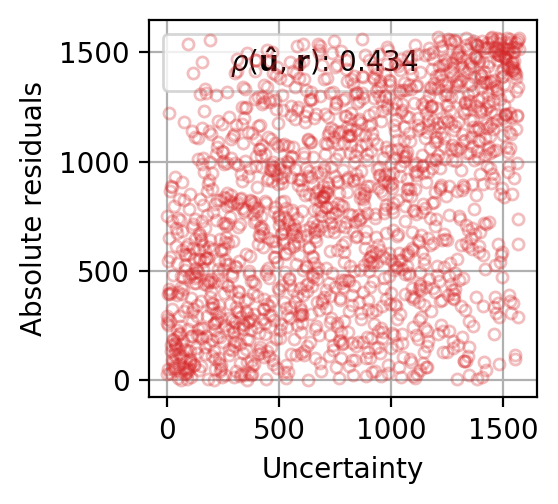

In [11]:
# Apply rank transformation
res_array = np.array(resd.abs())
res_order = res_array.argsort()
res_ranks = res_order.argsort()

uqs_array = np.array(uqs)
uqs_order = uqs_array.argsort()
uqs_ranks = uqs_order.argsort()

plot_scatter(
    res_ranks,
    uqs_ranks,
    color_i=3,
    custom_label=r'$\rho$' + r'($\mathbf{\hat{u}}$, ' + r'$\mathbf{r}$' + f'): {.434}      ',
    #custom_u_range=[.25, .5, .75, 1.],
    path=PLOT_FOLDER+f'scatter_{member_i}_members_custom_rank_transformed.pdf'
)

Confidence

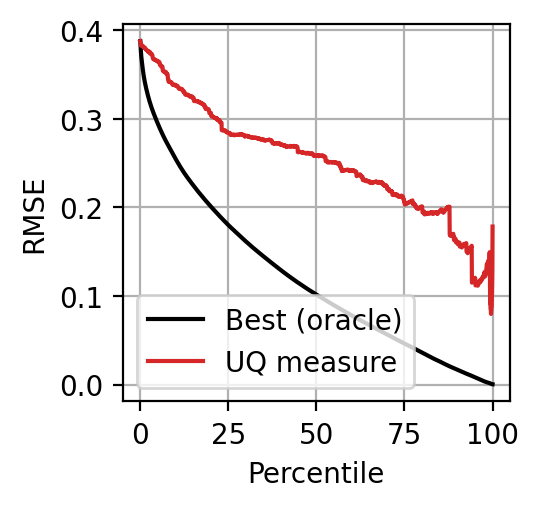

In [12]:
plot_confidence(resd.abs(), uqs, color_i=3, path=PLOT_FOLDER+f'confidence_{member_i}_members_custom.pdf', custom_label='UQ measure')

$R^2$ zoom in

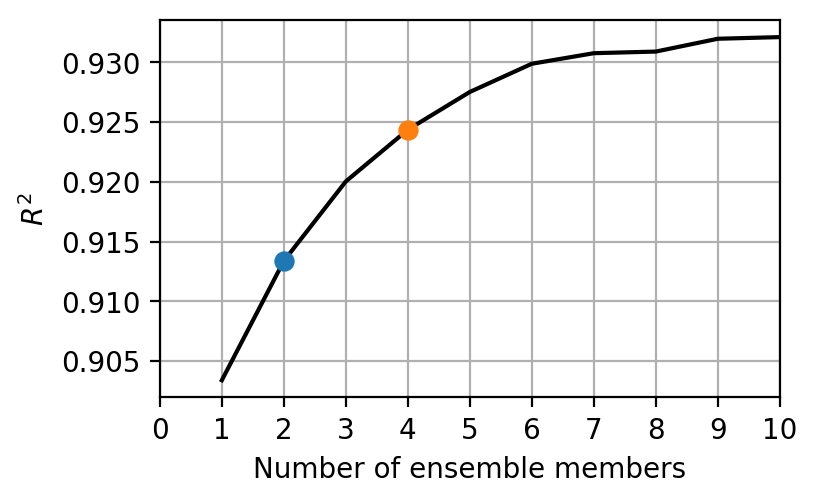

In [13]:
single_tables = load_results_file('esol', 'shallow', 'cddd')
y = load_true('esol')
r2_scores, uqs = cumulative_performance(single_tables, y)
plt.figure(figsize=(4, 2.5))
plt.grid(zorder=1000)
plt.plot(range(1, 11), r2_scores[:10], zorder=100, color='k')
plt.scatter([2], [r2_scores[1]], color='C0', s=40, zorder=101)
plt.scatter([4], [r2_scores[3]], color='C1', s=40, zorder=101)
plt.xticks(range(11), [f'{i}' for i in range(11)])
y_range = np.arange(.905, 0.93, .005)
plt.yticks(y_range, [f'{i:.3f}' for i in y_range])
plt.xlim(0, 10)
plt.xlabel('Number of ensemble members')
plt.ylabel('$R^2$')
path = PLOT_FOLDER+'esol/r2_zoom.pdf'
plt.savefig(path, bbox_inches='tight', pad_inches=0.05)
plt.show()